# **1. Imports**

In [1]:
# === Core Python Libraries ===
import os
import json
import random
from datetime import datetime
from collections import Counter

# === Image Handling ===
from PIL import Image

# === Numerical and Data Visualization Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Scikit-learn for Evaluation Metrics ===
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error

# === TensorFlow / Keras ===
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.utils import Sequence

# === PyTorch ===
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

# === Google Colab / Kaggle Integration ===
from google.colab import drive
import kagglehub

# **2. Definitions**

## Saving function

In [2]:
def save_training_checkpoint(model, history=None, save_dir="/content/drive/Shareddrives/deep learning/FACIAL_EMOTION_RECOGNITION/PROJECTE_COLLAB/training_checkpoints", filename="model", note=""):
    os.makedirs(save_dir, exist_ok=True)

    # Timestamp + base name
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    base_name = f"{timestamp}_{filename}"

    # Create a subfolder for this run
    run_dir = os.path.join(save_dir, base_name)
    os.makedirs(run_dir, exist_ok=True)

    # 1. Save model weights
    weights_path = os.path.join(run_dir, "weights.weights.h5")
    model.save_weights(weights_path)

    # 2. Prepare summary
    summary_data = {
        "timestamp": timestamp,
        "filename": filename,
        "note": note,
        "weights_file": weights_path
    }

    if history is not None:
        last_epoch = len(history.history['accuracy']) - 1
        summary_data.update({
            "epochs": len(history.history['accuracy']),
            "final_train_accuracy": float(history.history['accuracy'][last_epoch]),
            "final_val_accuracy": float(history.history['val_accuracy'][last_epoch]),
            "final_train_loss": float(history.history['loss'][last_epoch]),
            "final_val_loss": float(history.history['val_loss'][last_epoch]),
            "best_val_accuracy": float(max(history.history['val_accuracy']))
        })

        # Store metrics for all epochs
        epoch_data = []
        for epoch in range(len(history.history['accuracy'])):
            epoch_data.append({
                "epoch": epoch + 1,
                "train_accuracy": float(history.history['accuracy'][epoch]),
                "val_accuracy": float(history.history['val_accuracy'][epoch]),
                "train_loss": float(history.history['loss'][epoch]),
                "val_loss": float(history.history['val_loss'][epoch])
            })

        summary_data["epoch_data"] = epoch_data

        # Save plot
        fig, ax = plt.subplots(figsize=(8, 5))
        ax.plot(history.history['accuracy'], label='Train Accuracy')
        ax.plot(history.history['val_accuracy'], label='Val Accuracy')
        ax.plot(history.history['loss'], '--', label='Train Loss')
        ax.plot(history.history['val_loss'], '--', label='Val Loss')
        ax.set_title('Training History')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Value')
        ax.legend()
        ax.grid(True)
        plot_path = os.path.join(run_dir, "plot.png")
        plt.savefig(plot_path)
        plt.close()

        summary_data["plot_file"] = plot_path

    # 4. Save the summary as a JSON file
    summary_path = os.path.join(run_dir, "summary.json")
    with open(summary_path, "w") as f:
        json.dump(summary_data, f, indent=4)

    # 5. Final message
    print(f"✔️ Files saved in: {run_dir}")
    print(f"  - Weights: {weights_path}")
    print(f"  - JSON summary: {summary_path}")
    if history is not None:
        print(f"  - Training plot: {plot_path}")

## Distribution plot

In [3]:
def plot_and_save_age_group_distribution(dataset, output_dir=None, title="Age group distribution", filename_prefix="age_group_distribution"):
    labels = []

    for _, label_tensor in dataset:
        #label one-hot: [11]
        class_index = label_tensor.argmax().item()
        labels.append(class_index)


    counts = Counter(labels)
    classes = list(range(11))
    frequencies = [counts.get(i, 0) for i in classes]


    group_names = [
        "0–2", "3–5","6–9", "10–12", "13–17",
        "18–24", "25–34","35–44", "45–54",
        "55–64", "65–75"
    ]


    plt.figure(figsize=(12, 5))
    plt.bar(classes, frequencies, color='cornflowerblue')
    plt.title(title)
    plt.xlabel("Age group")
    plt.ylabel("Number of images")
    plt.xticks(classes, group_names, rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

## Evaluation Function

In [4]:
def evaluate_detailed_metrics(model, dataset, batch_size=128):
    y_true = []
    y_pred = []

    for i in range(0, len(dataset), batch_size):
        batch = []
        labels = []
        for j in range(i, min(i + batch_size, len(dataset))):
            image, label = dataset[j]
            image_np = image.numpy().transpose(1, 2, 0)  # (48, 48, 1)
            label_np = label.numpy()  # (11,)
            batch.append(image_np)
            labels.append(np.argmax(label_np))  # true class index

        x_batch = np.array(batch).astype('float32')
        y_true.extend(labels)

        y_probs = model.predict(x_batch, verbose=0)
        y_pred.extend(np.argmax(y_probs, axis=1))

    # Classification Report
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, zero_division=0, digits=4))

    # MAE
    mae = mean_absolute_error(y_true, y_pred)
    print(f"\n📉 Mean Absolute Error (MAE): {mae:.4f} (in age group units)")

    # Confusion Matrix
    AGE_GROUPS = [
        (0, 2), (3, 5), (6, 9), (10, 12), (13, 17),
        (18, 24), (25, 34), (35, 44), (45, 54),
        (55, 64), (65, 75)
    ]
    group_labels = [f"{low}-{high}" for (low, high) in AGE_GROUPS]

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(AGE_GROUPS)))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=group_labels,
                yticklabels=group_labels)
    plt.title("Confusion Matrix (Age Groups)")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.tight_layout()
    plt.show()


## Dataset adaptaion

In [5]:
class TorchDatasetToKeras(Sequence):
    def __init__(self, dataset, batch_size=32, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.dataset))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.dataset) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []
        batch_labels = []
        for i in batch_indices:
            image, label = self.dataset[i]
            batch_images.append(image.numpy())  # image: tensor (1,48,48)
            batch_labels.append(label.numpy())  # label: one-hot vector (11,)
        x = np.stack(batch_images).astype("float32")  # (batch, 1, 48, 48)
        x = np.transpose(x, (0, 2, 3, 1))             # → (batch, 48, 48, 1)
        y = np.stack(batch_labels).astype("float32")
        return x, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# **3. Dataset Uploading**

In [6]:
# Download the latest version of the UTKFace dataset using KaggleHub
path = kagglehub.dataset_download("jangedoo/utkface-new")

# Define the path to the image directory
image_dir = os.path.join(path, "utkface_aligned_cropped", "UTKFace")

# List all image files in the dataset
files = os.listdir(image_dir)
print("Total images:", len(files))
print("Example file:", files[0])

Total images: 23708
Example file: 26_0_2_20170104023102422.jpg.chip.jpg


In [7]:
# === AGE GROUPING: Dataset preparation for 11 age groups ===

# Define 11 age groups as tuples (low, high)
AGE_GROUPS = [
    (0, 2), (3, 5), (6, 9), (10, 12), (13, 17),
    (18, 24), (25, 34), (35, 44), (45, 54),
    (55, 64), (65, 75)
]

# Map each age to its corresponding group index (0 to 10)
def map_age_to_group(age):
    for i, (low, high) in enumerate(AGE_GROUPS):
        if low <= age <= high:
            return i
    return None  # Exclude ages outside defined ranges

# Collect all valid image files and assign group labels
def get_grouped_image_files(image_dir):
    image_files = []
    for f in os.listdir(image_dir):
        if f.endswith('.jpg'):
            try:
                age = int(f.split('_')[0])
                group = map_age_to_group(age)
                if group is not None:
                    image_files.append((f, group))
            except:
                continue
    return image_files

# Dataset class for grouped age classification (11 classes)
class UTKGroupedDataset(Dataset):
    def __init__(self, image_dir, image_files=None, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = image_files if image_files else get_grouped_image_files(image_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name, group = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = torch.zeros(11)
        label[group] = 1.0
        return image, label

# Define base and augmented transforms
base_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

augmentation_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor()
])

# Load dataset from disk
image_dir = os.path.join(path, "utkface_aligned_cropped/UTKFace")
grouped_files = get_grouped_image_files(image_dir)

# Split dataset into train, validation, and test
random.shuffle(grouped_files)
total_size = len(grouped_files)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_files = grouped_files[:train_size]
val_files = grouped_files[train_size:train_size + val_size]
test_files = grouped_files[train_size + val_size:]

# Optional: balance training data with augmentation
def balance_augmentation(train_files):
    label_counts = Counter([g for _, g in train_files])
    max_count = max(label_counts.values())
    augmented = []
    for group in range(11):
        group_files = [(f, g) for f, g in train_files if g == group]
        if not group_files:
            continue
        n_to_add = max_count - len(group_files)
        augmented_group = group_files * (n_to_add // len(group_files)) + random.choices(group_files, k=n_to_add % len(group_files))
        augmented.extend(group_files + augmented_group)
    return augmented

# Enable or disable data augmentation for training
apply_augmentation = False  # ← Set this to True if needed
if apply_augmentation:
    train_files = balance_augmentation(train_files)
    train_transform = augmentation_transform
else:
    train_transform = base_transform

# Create PyTorch datasets
train_dataset = UTKGroupedDataset(image_dir, image_files=train_files, transform=train_transform)
val_dataset   = UTKGroupedDataset(image_dir, image_files=val_files,   transform=base_transform)
test_dataset  = UTKGroupedDataset(image_dir, image_files=test_files,  transform=base_transform)

# Create PyTorch DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Convert to Keras generators (if using tf.keras for training)
train_gen = TorchDatasetToKeras(train_dataset, batch_size=32)
val_gen   = TorchDatasetToKeras(val_dataset, batch_size=32)

# **4. New Dataseet**

TRAIN SET

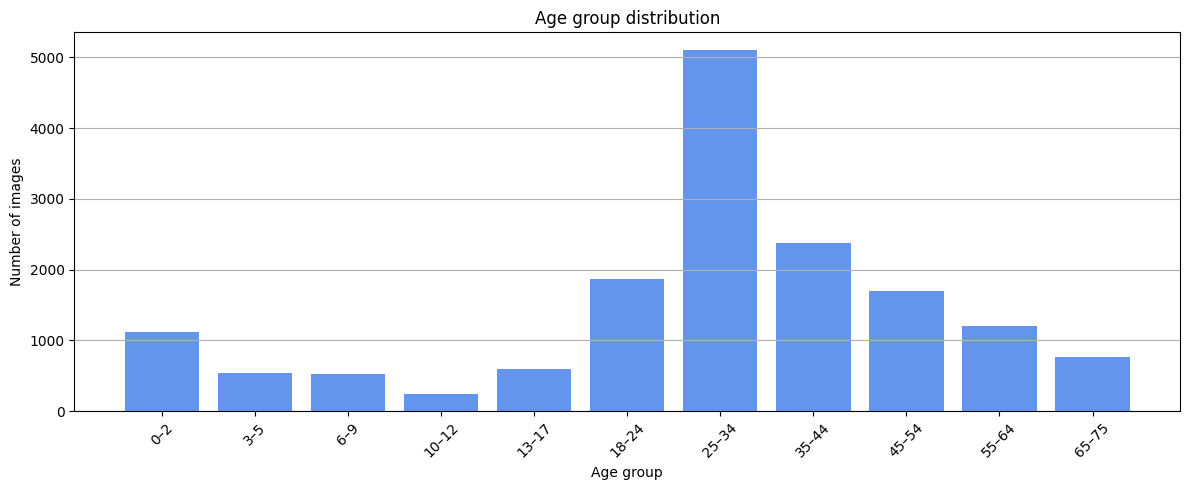

In [ ]:
plot_and_save_age_group_distribution(train_dataset)

VALIDATION SET

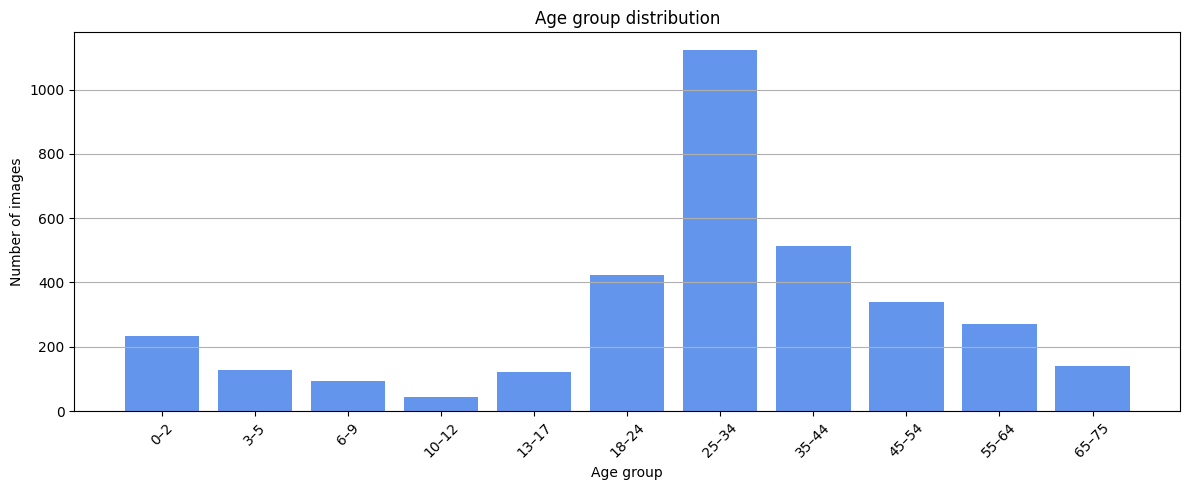

In [ ]:
plot_and_save_age_group_distribution(val_dataset)

# **5. MODEL DEFINITION**

#5.1. CHOSE THE WEIGHTS TO LOAD (maybe first part needs to be changed)

In [10]:
# Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


### Best weights from the ORIGINAL + 1FC

In [17]:
weights_path = "/content/drive/MyDrive/FACIAL AGE CLASSIFICATION/CODE/RESULTS/11_outputs/Second Phase/weights.weights.h5"

## Best weights from the ORIGINAL + 1FC DATA AUGMENTATION

In [14]:
weights_path = "/content/drive/MyDrive/FACIAL AGE CLASSIFICATION/CODE/RESULTS/11_outputs/With data augmentation (Second Phase)/weights.weights.h5"

# 5.2. Origial CNN + 1FC

In [18]:
model = Sequential([

    # Bloc convolucional 1
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)),
    BatchNormalization(),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Bloc convolucional 2
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Bloc convolucional 3
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),


    Flatten(),


    Dense(512, activation='relu'),             #  NEW
    BatchNormalization(),                      #  NEW
    Dropout(0.5),                              #  NEW


    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    #11 outputs
    Dense(11, activation='softmax')
])

# Compile
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

#Load weights
model.load_weights(weights_path, skip_mismatch=False)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 44, 44, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 5, 5, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 5, 5, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,790,987 (6.83 MB)

 Trainable params: 1,787,723 (6.82 MB)

 Non-trainable params: 3,264 (12.75 KB)

# 6. The data augmentation training (just to show an example)

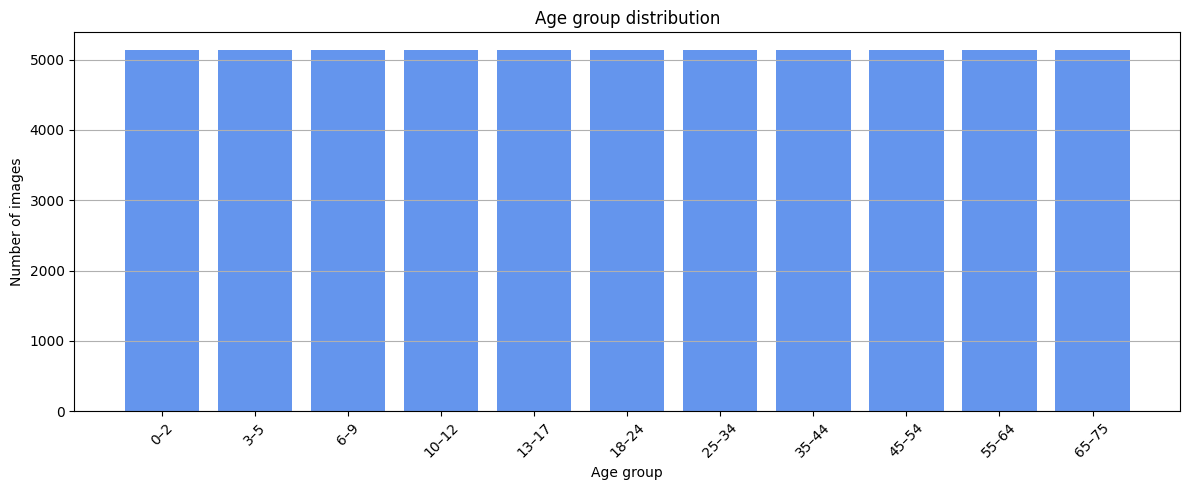

In [ ]:
plot_and_save_age_group_distribution(train_dataset)

In [ ]:

for layer in model.layers[:-1]:
    layer.trainable = False


for layer in model.layers[-18:]:
    layer.trainable = True

model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)
for i, layer in enumerate(model.layers):
    status = "Trainable" if layer.trainable else "Frozen"
    print(f"{i:2d} - {layer.name:30s} - {status}")

 0 - conv2d                         - Frozen
 1 - batch_normalization            - Frozen
 2 - conv2d_1                       - Frozen
 3 - batch_normalization_1          - Frozen
 4 - max_pooling2d                  - Frozen
 5 - dropout                        - Frozen
 6 - conv2d_2                       - Frozen
 7 - batch_normalization_2          - Frozen
 8 - conv2d_3                       - Trainable
 9 - batch_normalization_3          - Trainable
10 - max_pooling2d_1                - Trainable
11 - dropout_1                      - Trainable
12 - conv2d_4                       - Trainable
13 - batch_normalization_4          - Trainable
14 - conv2d_5                       - Trainable
15 - batch_normalization_5          - Trainable
16 - max_pooling2d_2                - Trainable
17 - dropout_2                      - Trainable
18 - flatten                        - Trainable
19 - dense                          - Trainable
20 - batch_normalization_6          - Trainable
21 - dropout_3  

## First Phase -> Moderate Learning Rate (Last iteration)

In [ ]:
history=model.fit(train_gen, validation_data=val_gen, epochs=10)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 230s 124ms/step - accuracy: 0.1876 - loss: 2.9316 - val_accuracy: 0.3256 - val_loss: 1.6989
Epoch 2/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 143s 61ms/step - accuracy: 0.3021 - loss: 1.9893 - val_accuracy: 0.3921 - val_loss: 1.4905
Epoch 3/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 109s 62ms/step - accuracy: 0.3351 - loss: 1.7284 - val_accuracy: 0.3856 - val_loss: 1.4483
Epoch 4/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 105s 60ms/step - accuracy: 0.3676 - loss: 1.5636 - val_accuracy: 0.3833 - val_loss: 1.4162
Epoch 5/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 105s 60ms/step - accuracy: 0.3939 - loss: 1.4675 - val_accuracy: 0.3900 - val_loss: 1.4062
Epoch 6/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 103s 59ms/step - accuracy: 0.4191 - loss: 1.4041 - val_accuracy: 0.4078 - val_loss: 1.3550
Epoch 7/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 103s 58ms/step - accuracy: 0.4382 - loss: 1.3593 - val_accuracy: 0.3813 - val_loss: 1.3739
Epoch 8/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 103s 59ms/step - accuracy:

## Second Phase -> Low Learning Rate (Last iteration)

In [ ]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
)
history=model.fit(train_gen, validation_data=val_gen, epochs=5)

Epoch 1/5
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 126s 66ms/step - accuracy: 0.4974 - loss: 1.2007 - val_accuracy: 0.4198 - val_loss: 1.2887
Epoch 2/5
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 105s 60ms/step - accuracy: 0.5053 - loss: 1.1961 - val_accuracy: 0.4256 - val_loss: 1.2829
Epoch 3/5
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 102s 58ms/step - accuracy: 0.5134 - loss: 1.1673 - val_accuracy: 0.4312 - val_loss: 1.2741
Epoch 4/5
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 148s 62ms/step - accuracy: 0.5109 - loss: 1.1732 - val_accuracy: 0.4271 - val_loss: 1.2718
Epoch 5/5
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 114s 65ms/step - accuracy: 0.5161 - loss: 1.1678 - val_accuracy: 0.4306 - val_loss: 1.2693


In [ ]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
)
history=model.fit(train_gen, validation_data=val_gen, epochs=5)

Epoch 1/5
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 119s 62ms/step - accuracy: 0.5187 - loss: 1.1644 - val_accuracy: 0.4312 - val_loss: 1.2734
Epoch 2/5
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 107s 61ms/step - accuracy: 0.5136 - loss: 1.1618 - val_accuracy: 0.4300 - val_loss: 1.2721
Epoch 3/5
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 108s 61ms/step - accuracy: 0.5215 - loss: 1.1532 - val_accuracy: 0.4312 - val_loss: 1.2723
Epoch 4/5
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 111s 63ms/step - accuracy: 0.5173 - loss: 1.1687 - val_accuracy: 0.4282 - val_loss: 1.2731
Epoch 5/5
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 105s 60ms/step - accuracy: 0.5215 - loss: 1.1561 - val_accuracy: 0.4294 - val_loss: 1.2705


In [ ]:
save_training_checkpoint(
    model,
    history,
    save_dir="/content/drive/Shareddrives/deep learning/FACIAL_EMOTION_RECOGNITION/PROJECTE_COLLAB/training_checkpoints",
    filename="11_Ranks_amb_data_augmentation",
    note="Rangs amb data augmentation -> millor acc: training 0.52 validation 0.47, després overfitting"
)

✔️ Fitxers guardats a: /content/drive/Shareddrives/deep learning/FACIAL_EMOTION_RECOGNITION/PROJECTE_COLLAB/training_checkpoints/2025-05-31_08-59-29_11_Ranks_amb_data_augmentation
  - Pesos: /content/drive/Shareddrives/deep learning/FACIAL_EMOTION_RECOGNITION/PROJECTE_COLLAB/training_checkpoints/2025-05-31_08-59-29_11_Ranks_amb_data_augmentation/weights.weights.h5
  - JSON : /content/drive/Shareddrives/deep learning/FACIAL_EMOTION_RECOGNITION/PROJECTE_COLLAB/training_checkpoints/2025-05-31_08-59-29_11_Ranks_amb_data_augmentation/summary.json
  - Gràfic: /content/drive/Shareddrives/deep learning/FACIAL_EMOTION_RECOGNITION/PROJECTE_COLLAB/training_checkpoints/2025-05-31_08-59-29_11_Ranks_amb_data_augmentation/plot.png


# 7. EVALUATION ON TESTING

## With best weights


📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9365    0.9516    0.9440       248
           1     0.7444    0.6634    0.7016       101
           2     0.5564    0.6981    0.6192       106
           3     1.0000    0.0638    0.1200        47
           4     0.5532    0.4127    0.4727       126
           5     0.6216    0.2260    0.3315       407
           6     0.6114    0.8494    0.7110      1102
           7     0.4926    0.4153    0.4507       484
           8     0.5175    0.5134    0.5154       374
           9     0.5714    0.4648    0.5126       284
          10     0.5858    0.6556    0.6188       151

    accuracy                         0.6076      3430
   macro avg     0.6537    0.5376    0.5452      3430
weighted avg     0.6101    0.6076    0.5843      3430


📉 Mean Absolute Error (MAE): 0.4714 (in age group units)


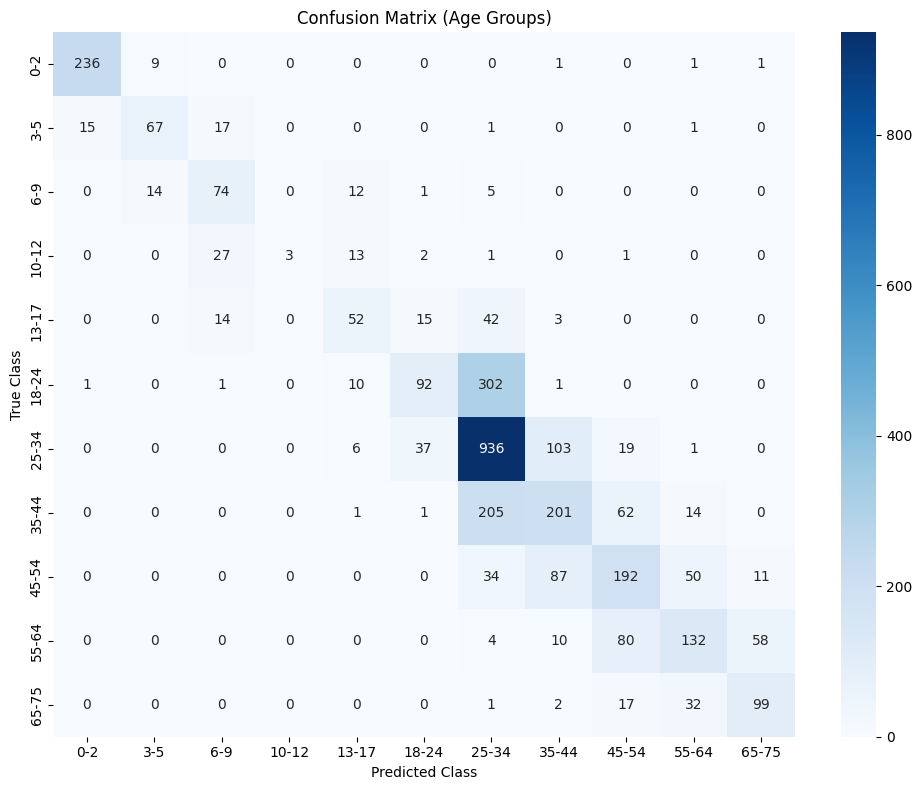

In [ ]:
evaluate_detailed_metrics(model, test_dataset)

### **EVALUATION AGE BY AGE**





In [ ]:
def get_selected_subset_by_age(dataset, selected_ages):
    """
    Returns a list of (image, label) from the dataset with exact ages matching selected_ages.
    """
    selected_samples = []
    for i in range(len(dataset)):
        img_name, _ = dataset.image_files[i]  # format: "age_...jpg"
        age = int(img_name.split('_')[0])
        if age in selected_ages:
            selected_samples.append(dataset[i])
    return selected_samples6

### (0-1) (2)


📊 Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9760    0.9879       167
           1     0.0000    0.0000    0.0000         0
           7     0.0000    0.0000    0.0000         0
           9     0.0000    0.0000    0.0000         0
          10     0.0000    0.0000    0.0000         0

    accuracy                         0.9760       167
   macro avg     0.2000    0.1952    0.1976       167
weighted avg     1.0000    0.9760    0.9879       167


📉 Mean Absolute Error (MAE): 0.1617 (en unitats de grup d’edat)


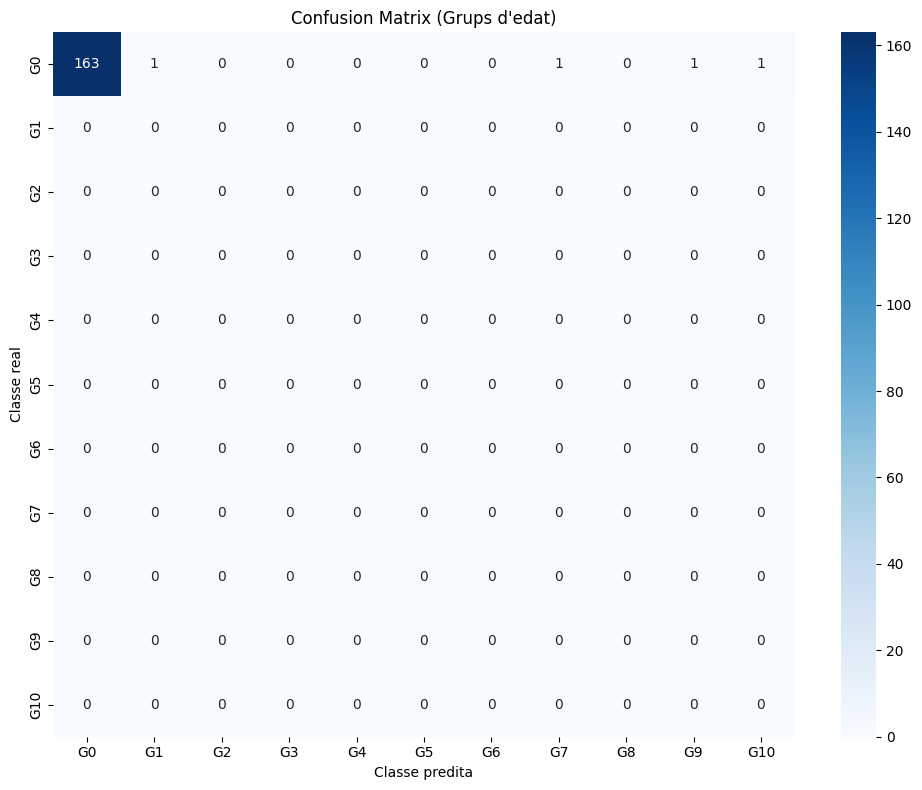


📊 Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9012    0.9481        81
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9012        81
   macro avg     0.5000    0.4506    0.4740        81
weighted avg     1.0000    0.9012    0.9481        81


📉 Mean Absolute Error (MAE): 0.0988 (en unitats de grup d’edat)


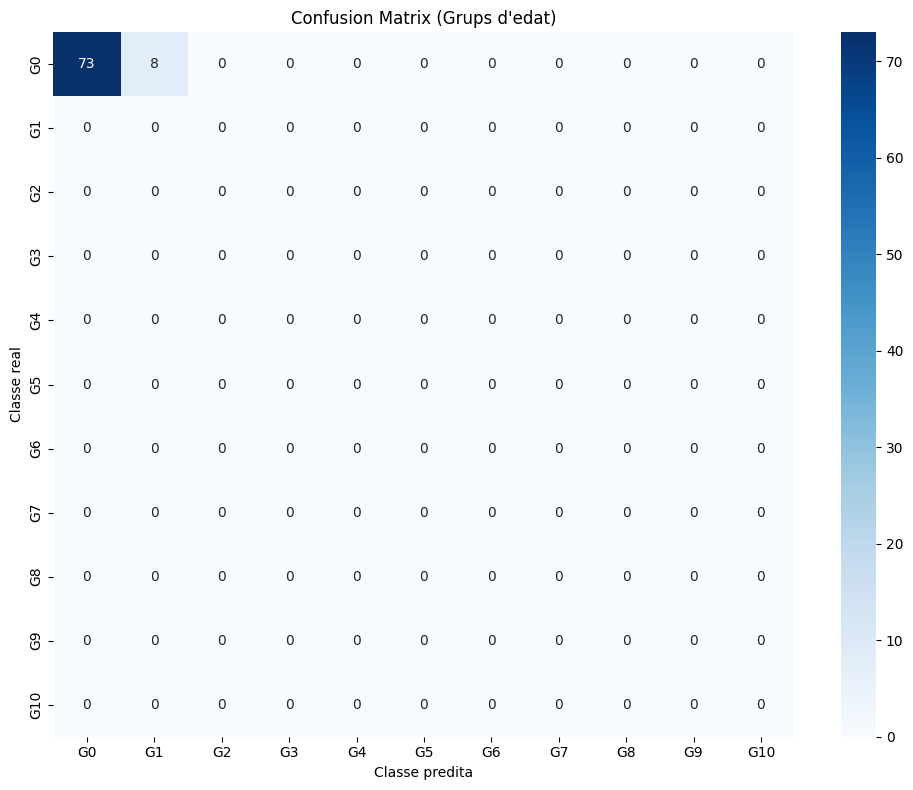

In [ ]:
SELECTED_AGES =[0,1]  # ← Modify as needed
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

SELECTED_AGES =[2]  # ← Modify as needed
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

### (10-12)


📊 Classification Report:
              precision    recall  f1-score   support

           2     0.0000    0.0000    0.0000         0
           3     1.0000    0.0526    0.1000        19
           4     0.0000    0.0000    0.0000         0
           5     0.0000    0.0000    0.0000         0
           6     0.0000    0.0000    0.0000         0
           8     0.0000    0.0000    0.0000         0

    accuracy                         0.0526        19
   macro avg     0.1667    0.0088    0.0167        19
weighted avg     1.0000    0.0526    0.1000        19


📉 Mean Absolute Error (MAE): 1.3158 (en unitats de grup d’edat)


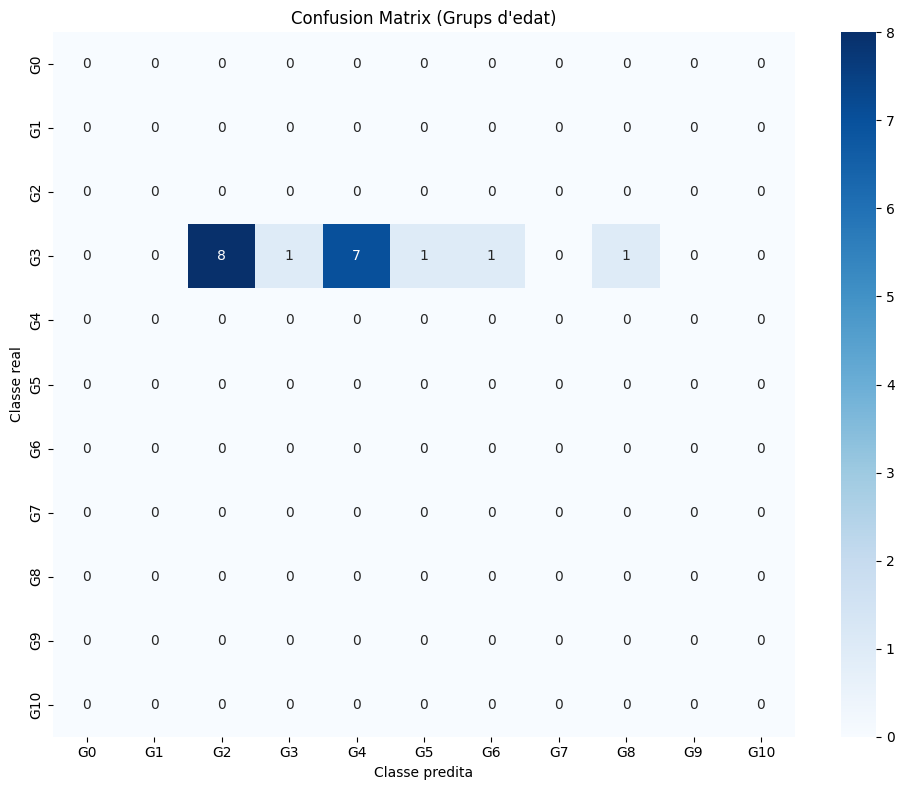


📊 Classification Report:
              precision    recall  f1-score   support

           2     0.0000    0.0000    0.0000         0
           3     1.0000    0.0833    0.1538        12
           4     0.0000    0.0000    0.0000         0

    accuracy                         0.0833        12
   macro avg     0.3333    0.0278    0.0513        12
weighted avg     1.0000    0.0833    0.1538        12


📉 Mean Absolute Error (MAE): 0.9167 (en unitats de grup d’edat)


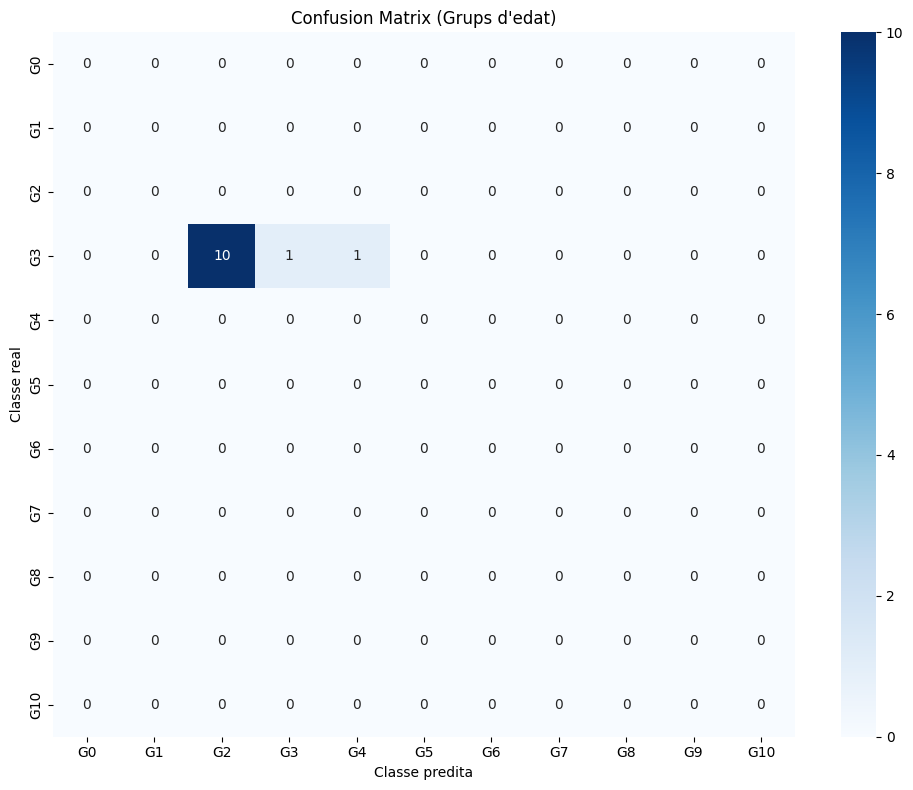


📊 Classification Report:
              precision    recall  f1-score   support

           2     0.0000    0.0000    0.0000         0
           3     1.0000    0.0625    0.1176        16
           4     0.0000    0.0000    0.0000         0
           5     0.0000    0.0000    0.0000         0

    accuracy                         0.0625        16
   macro avg     0.2500    0.0156    0.0294        16
weighted avg     1.0000    0.0625    0.1176        16


📉 Mean Absolute Error (MAE): 1.0000 (en unitats de grup d’edat)


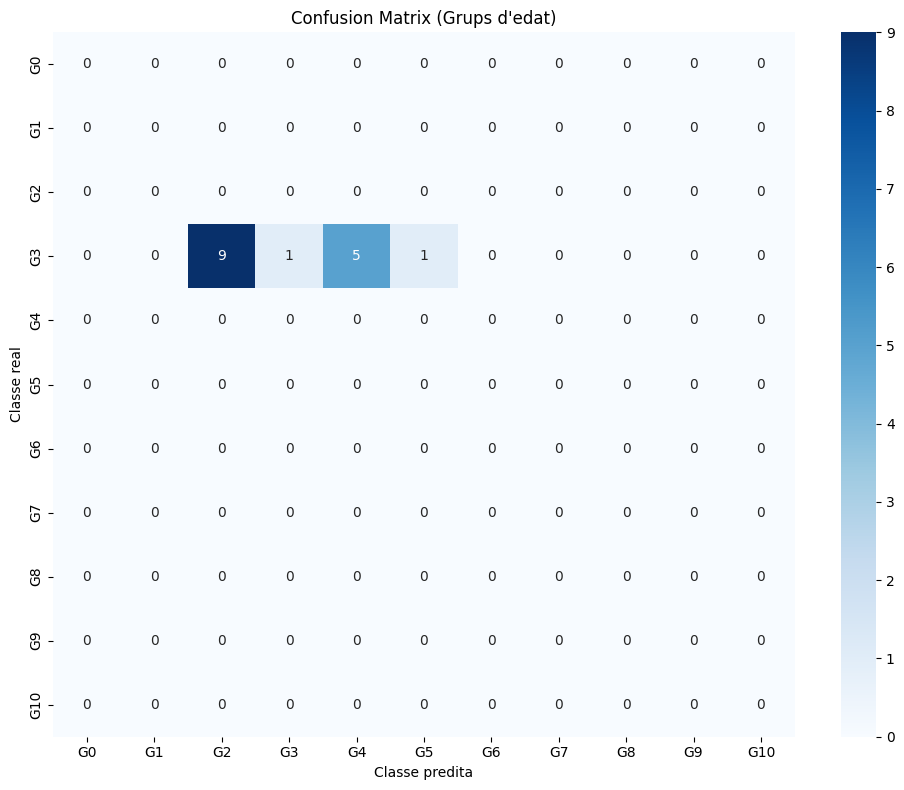

In [ ]:

SELECTED_AGES =[10]  # ← Modify as needed
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

SELECTED_AGES =[11]  # ← Modify as needed
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)


SELECTED_AGES =[12]  # ← Modify as needed
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

### (13-17)

[13] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           2     0.0000    0.0000    0.0000         0
           4     1.0000    0.5714    0.7273         7

    accuracy                         0.5714         7
   macro avg     0.5000    0.2857    0.3636         7
weighted avg     1.0000    0.5714    0.7273         7


📉 Mean Absolute Error (MAE): 0.8571 (in age group units)


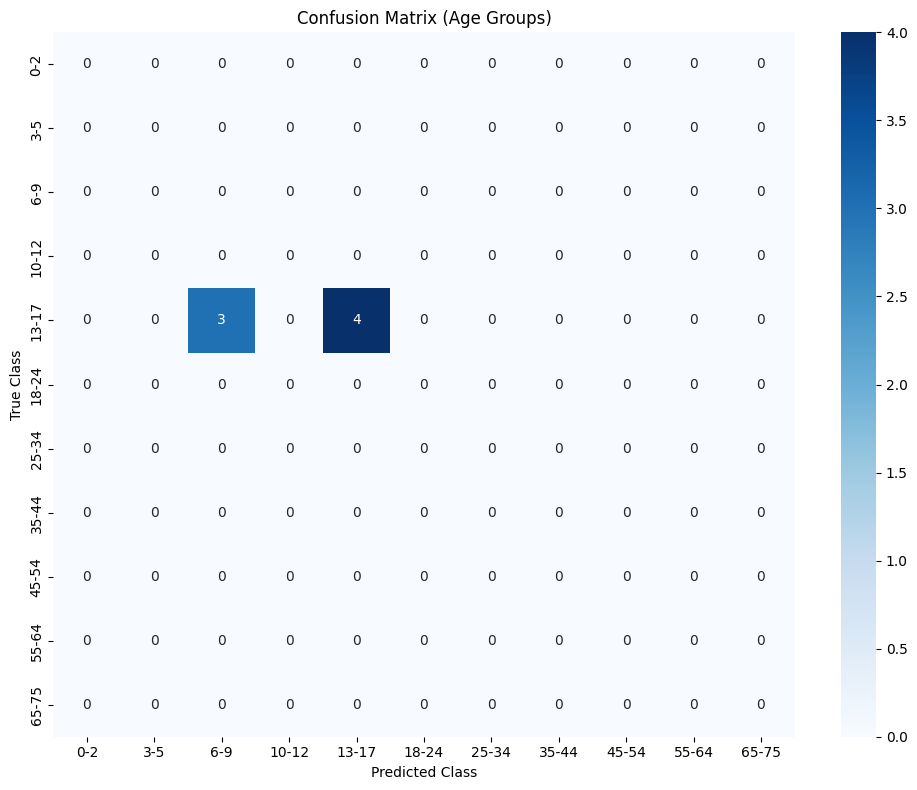

[14] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           2     0.0000    0.0000    0.0000         0
           4     1.0000    0.5833    0.7368        24
           5     0.0000    0.0000    0.0000         0
           6     0.0000    0.0000    0.0000         0

    accuracy                         0.5833        24
   macro avg     0.2500    0.1458    0.1842        24
weighted avg     1.0000    0.5833    0.7368        24


📉 Mean Absolute Error (MAE): 0.7500 (in age group units)


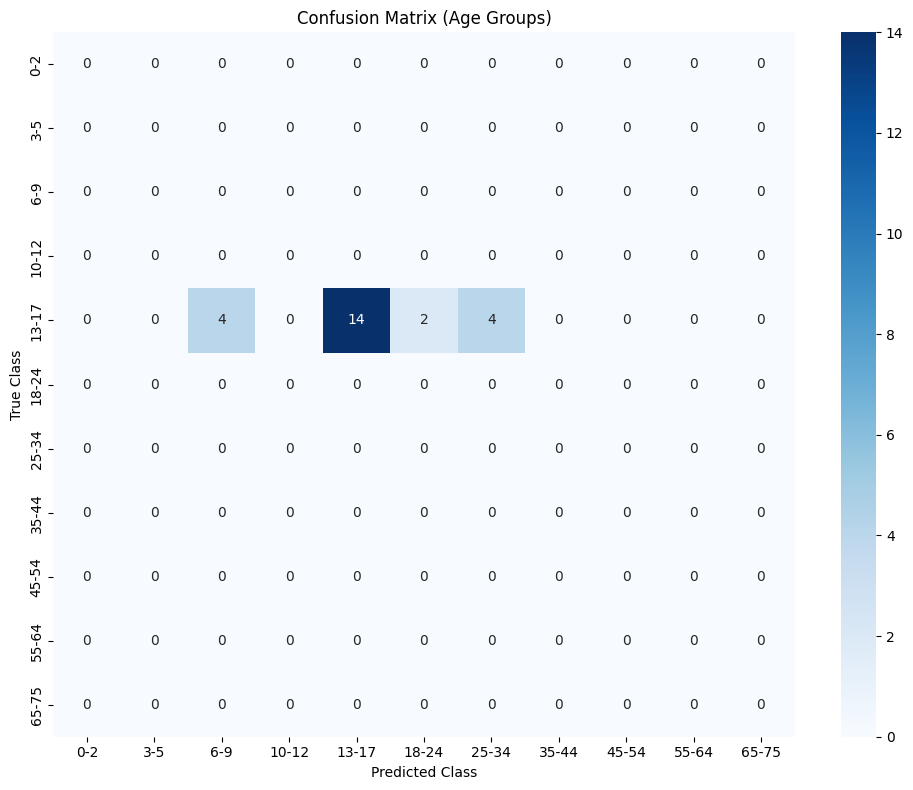

[15] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           2     0.0000    0.0000    0.0000         0
           4     1.0000    0.3667    0.5366        30
           5     0.0000    0.0000    0.0000         0
           6     0.0000    0.0000    0.0000         0
           7     0.0000    0.0000    0.0000         0

    accuracy                         0.3667        30
   macro avg     0.2000    0.0733    0.1073        30
weighted avg     1.0000    0.3667    0.5366        30


📉 Mean Absolute Error (MAE): 1.1667 (in age group units)


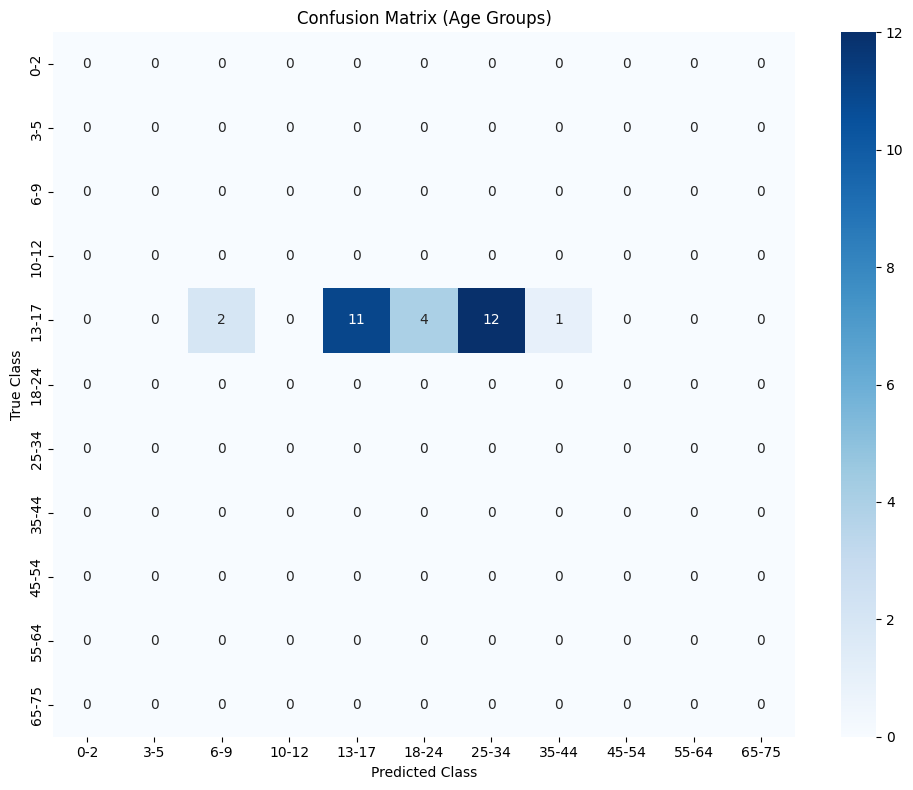

[16] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           2     0.0000    0.0000    0.0000         0
           4     1.0000    0.3953    0.5667        43
           5     0.0000    0.0000    0.0000         0
           6     0.0000    0.0000    0.0000         0
           7     0.0000    0.0000    0.0000         0

    accuracy                         0.3953        43
   macro avg     0.2000    0.0791    0.1133        43
weighted avg     1.0000    0.3953    0.5667        43


📉 Mean Absolute Error (MAE): 1.1628 (in age group units)


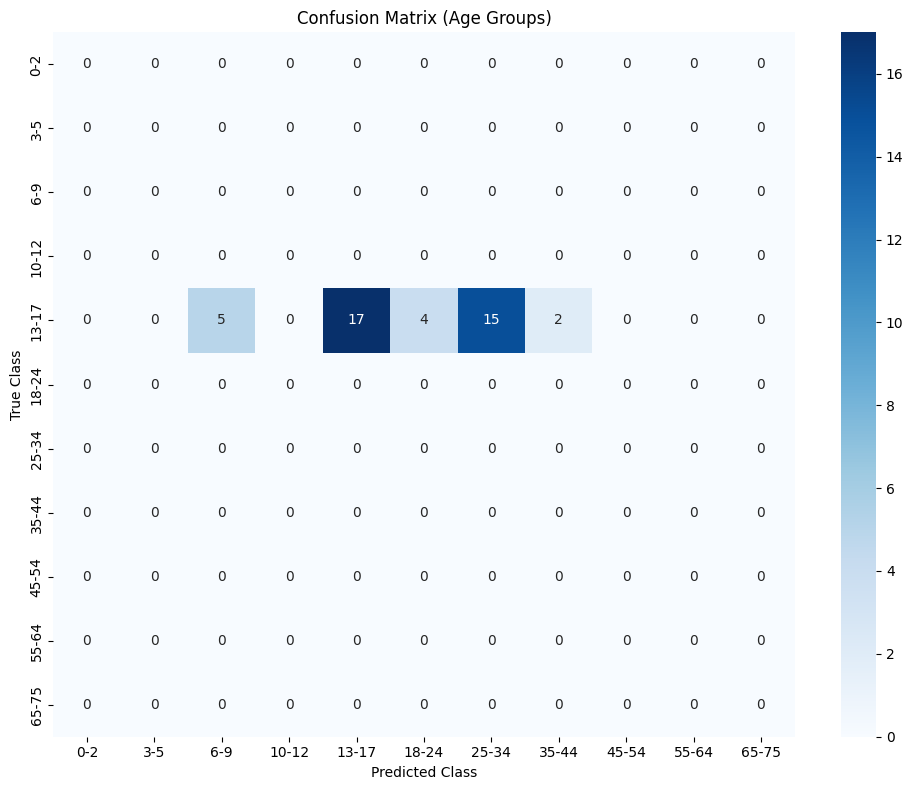

[17] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           4     1.0000    0.2727    0.4286        22
           5     0.0000    0.0000    0.0000         0
           6     0.0000    0.0000    0.0000         0

    accuracy                         0.2727        22
   macro avg     0.3333    0.0909    0.1429        22
weighted avg     1.0000    0.2727    0.4286        22


📉 Mean Absolute Error (MAE): 1.2273 (in age group units)


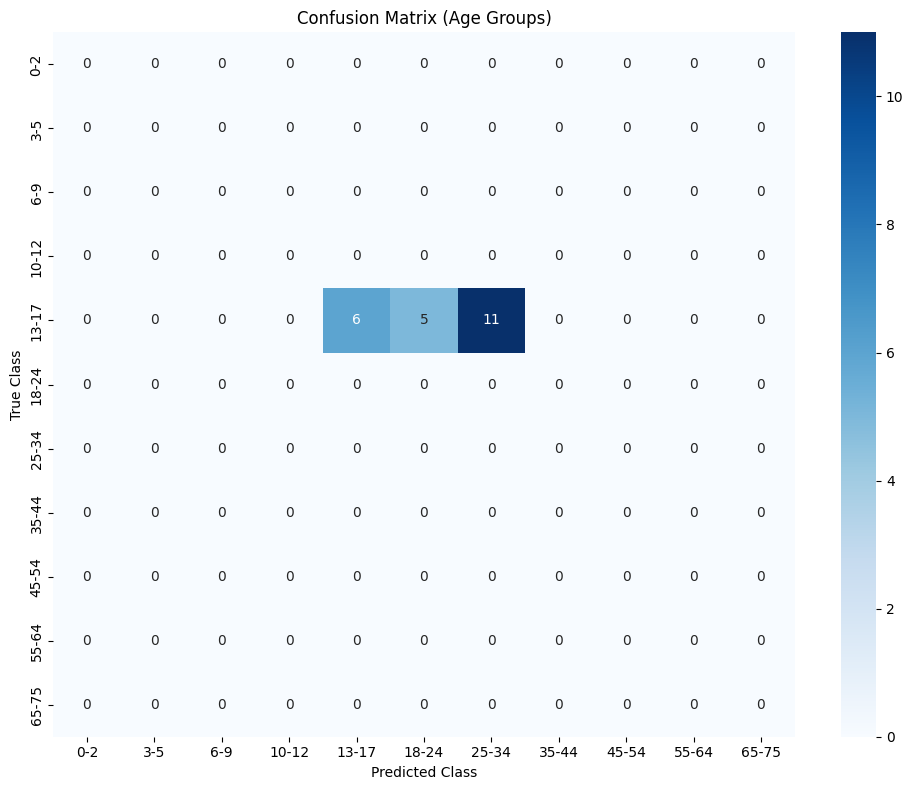

In [ ]:

SELECTED_AGES =[13]
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

SELECTED_AGES =[14]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)


SELECTED_AGES =[15]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)


SELECTED_AGES =[16]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)


SELECTED_AGES =[17]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

### (18-24)

[18] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           2     0.0000    0.0000    0.0000         0
           4     0.0000    0.0000    0.0000         0
           5     1.0000    0.3684    0.5385        38
           6     0.0000    0.0000    0.0000         0

    accuracy                         0.3684        38
   macro avg     0.2500    0.0921    0.1346        38
weighted avg     1.0000    0.3684    0.5385        38


📉 Mean Absolute Error (MAE): 0.6842 (in age group units)


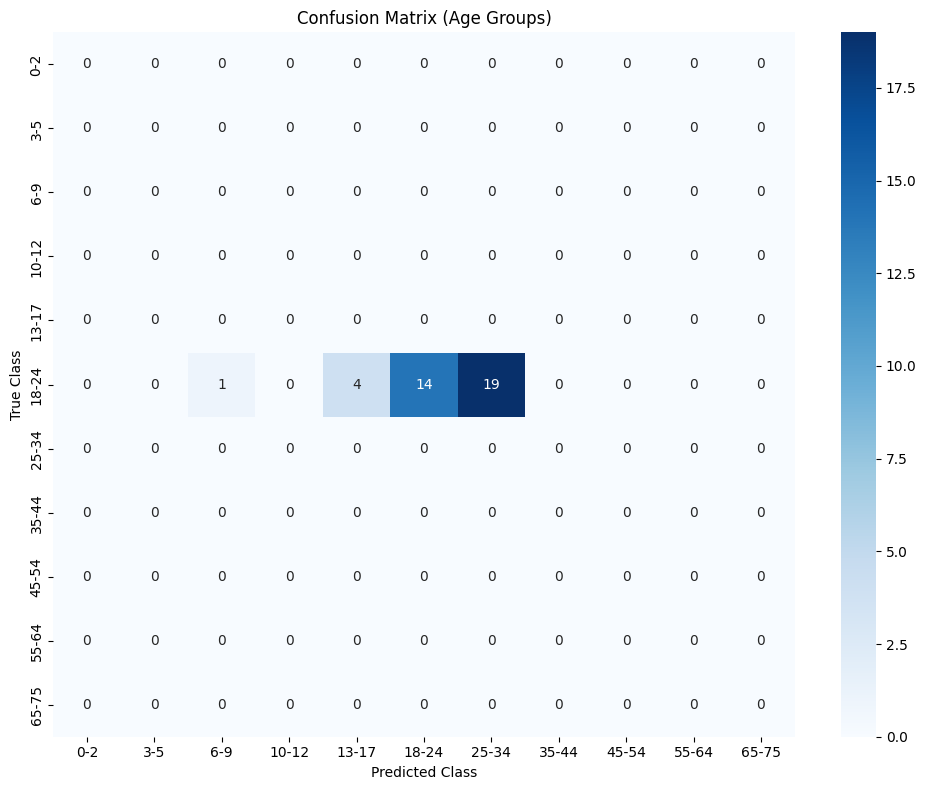

[19] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           4     0.0000    0.0000    0.0000         0
           5     1.0000    0.2353    0.3810        17
           6     0.0000    0.0000    0.0000         0

    accuracy                         0.2353        17
   macro avg     0.3333    0.0784    0.1270        17
weighted avg     1.0000    0.2353    0.3810        17


📉 Mean Absolute Error (MAE): 0.7647 (in age group units)


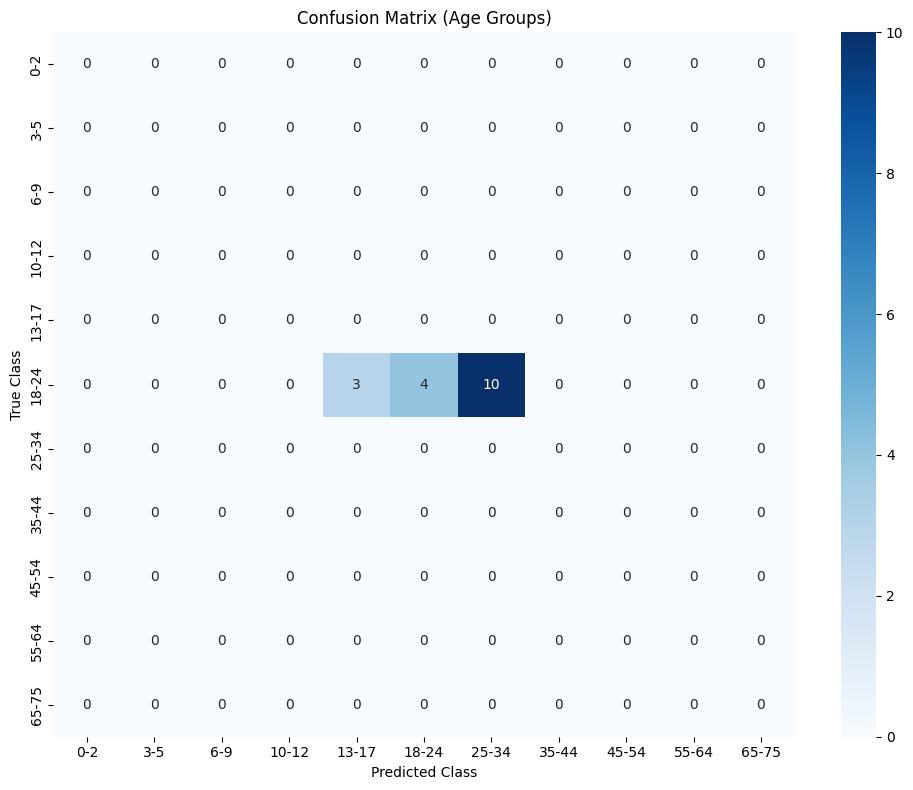

[20] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           4     0.0000    0.0000    0.0000         0
           5     1.0000    0.2273    0.3704        44
           6     0.0000    0.0000    0.0000         0

    accuracy                         0.2273        44
   macro avg     0.3333    0.0758    0.1235        44
weighted avg     1.0000    0.2273    0.3704        44


📉 Mean Absolute Error (MAE): 0.7727 (in age group units)


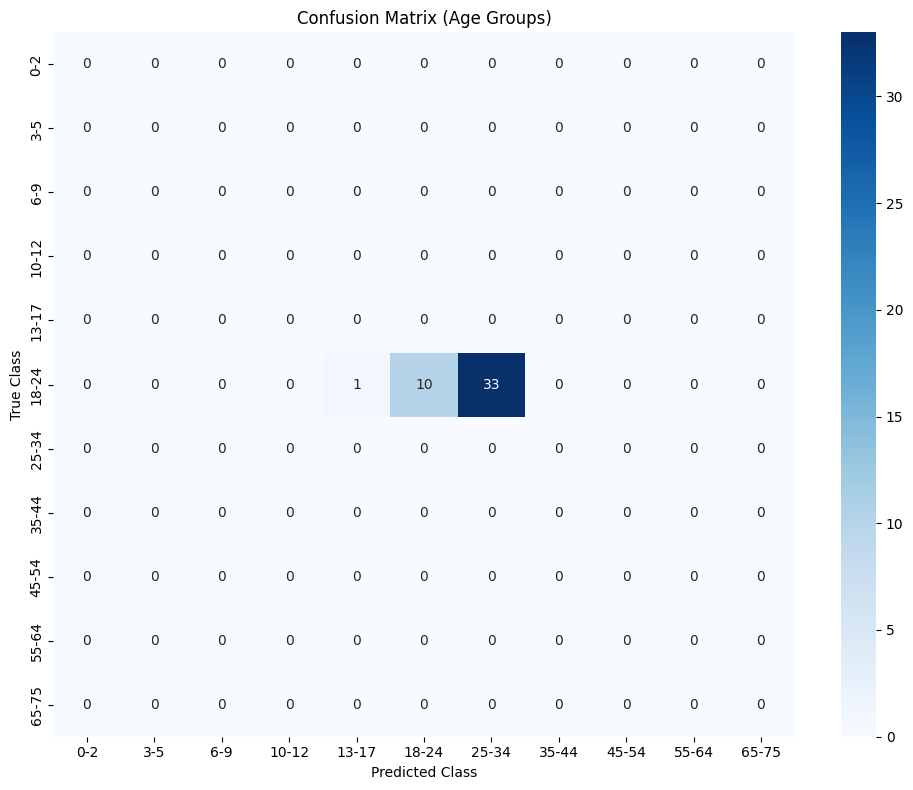

[21] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           5     1.0000    0.2917    0.4516        48
           6     0.0000    0.0000    0.0000         0

    accuracy                         0.2917        48
   macro avg     0.3333    0.0972    0.1505        48
weighted avg     1.0000    0.2917    0.4516        48


📉 Mean Absolute Error (MAE): 0.7917 (in age group units)


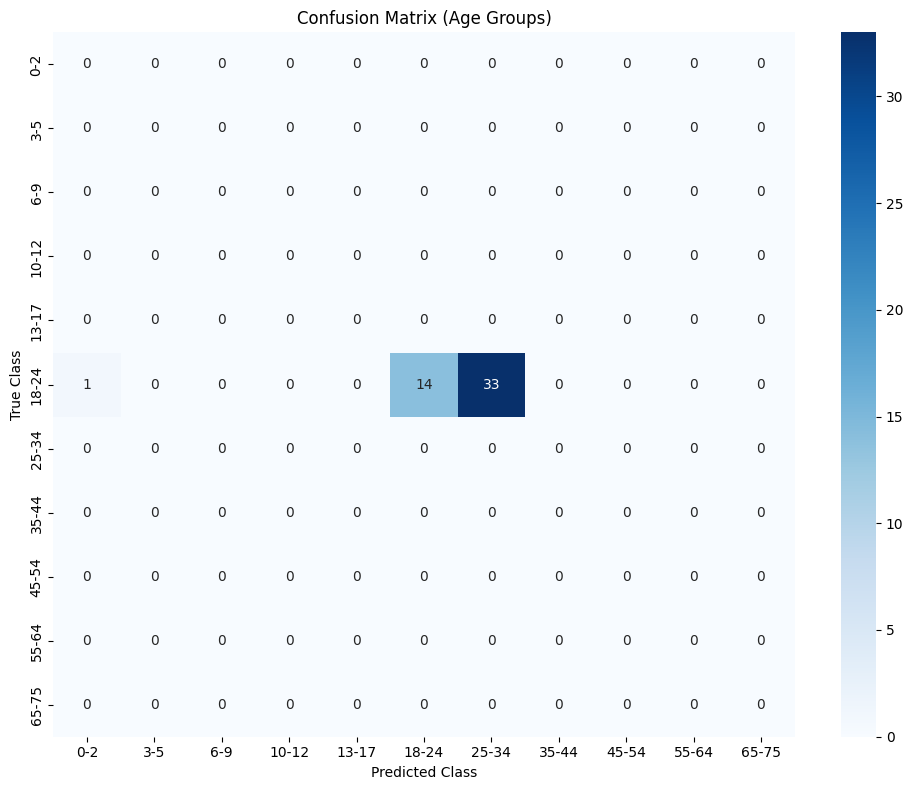

[22] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           5     1.0000    0.2115    0.3492        52
           6     0.0000    0.0000    0.0000         0
           7     0.0000    0.0000    0.0000         0

    accuracy                         0.2115        52
   macro avg     0.3333    0.0705    0.1164        52
weighted avg     1.0000    0.2115    0.3492        52


📉 Mean Absolute Error (MAE): 0.8077 (in age group units)


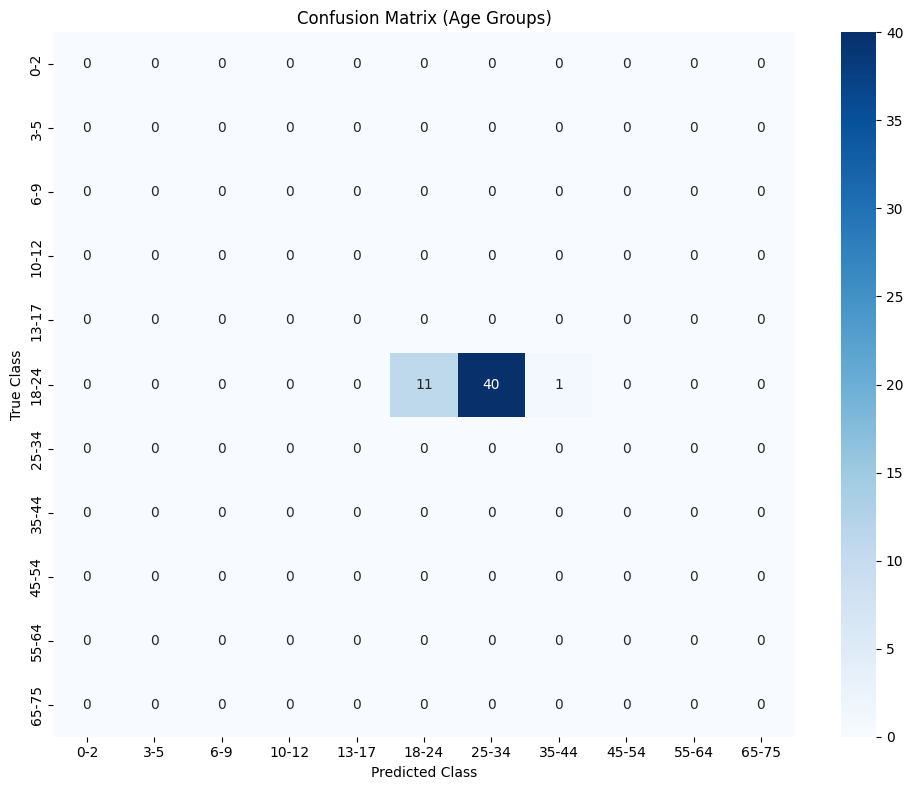

[23] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           4     0.0000    0.0000    0.0000         0
           5     1.0000    0.2361    0.3820        72
           6     0.0000    0.0000    0.0000         0

    accuracy                         0.2361        72
   macro avg     0.3333    0.0787    0.1273        72
weighted avg     1.0000    0.2361    0.3820        72


📉 Mean Absolute Error (MAE): 0.7639 (in age group units)


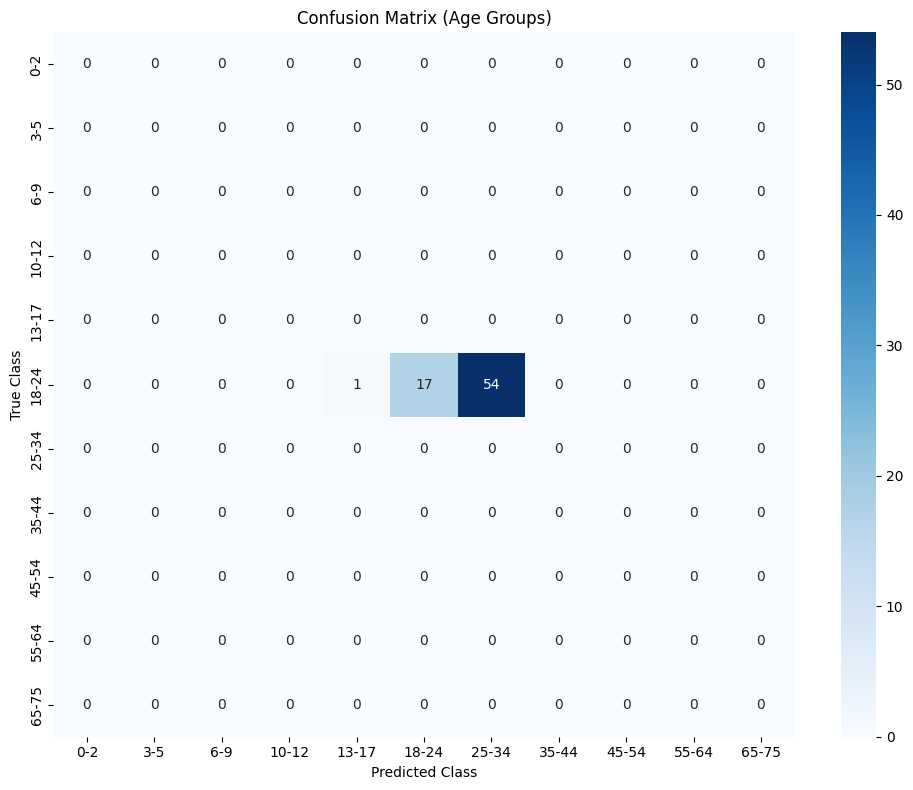

[24] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           4     0.0000    0.0000    0.0000         0
           5     1.0000    0.1618    0.2785       136
           6     0.0000    0.0000    0.0000         0

    accuracy                         0.1618       136
   macro avg     0.3333    0.0539    0.0928       136
weighted avg     1.0000    0.1618    0.2785       136


📉 Mean Absolute Error (MAE): 0.8382 (in age group units)


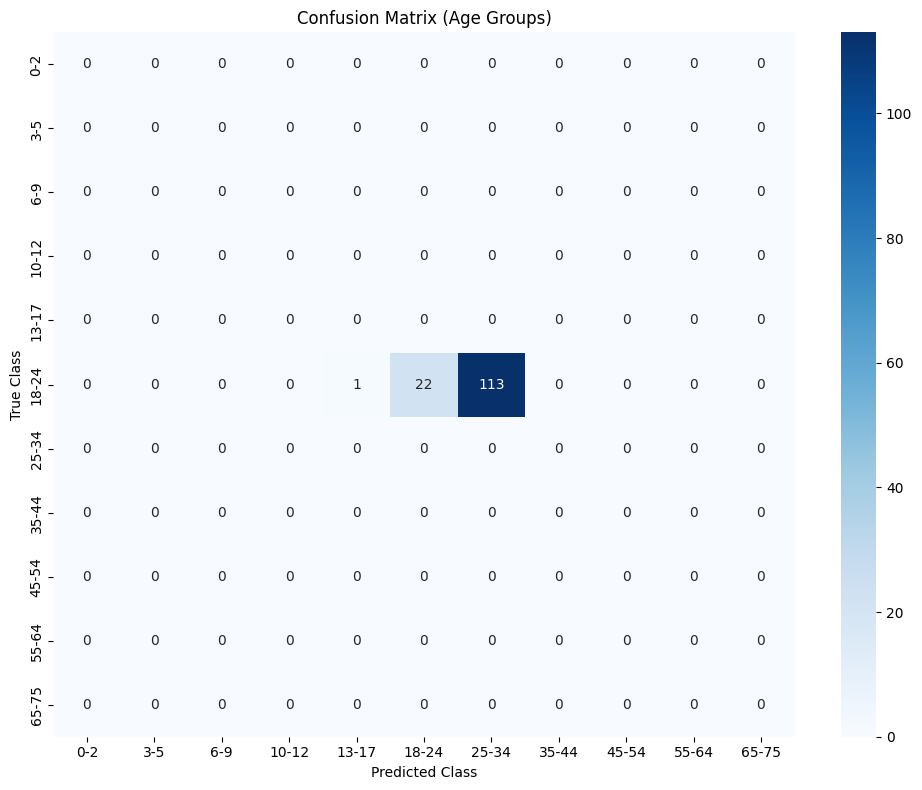

In [ ]:

SELECTED_AGES =[18]
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

SELECTED_AGES =[19]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)


SELECTED_AGES =[20]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)


SELECTED_AGES =[21]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)


SELECTED_AGES =[22]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

SELECTED_AGES =[23]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)


SELECTED_AGES =[24]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

### (25-34)

[25] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           4     0.0000    0.0000    0.0000         0
           5     0.0000    0.0000    0.0000         0
           6     1.0000    0.8273    0.9055       110
           7     0.0000    0.0000    0.0000         0
           8     0.0000    0.0000    0.0000         0

    accuracy                         0.8273       110
   macro avg     0.2000    0.1655    0.1811       110
weighted avg     1.0000    0.8273    0.9055       110


📉 Mean Absolute Error (MAE): 0.2091 (in age group units)


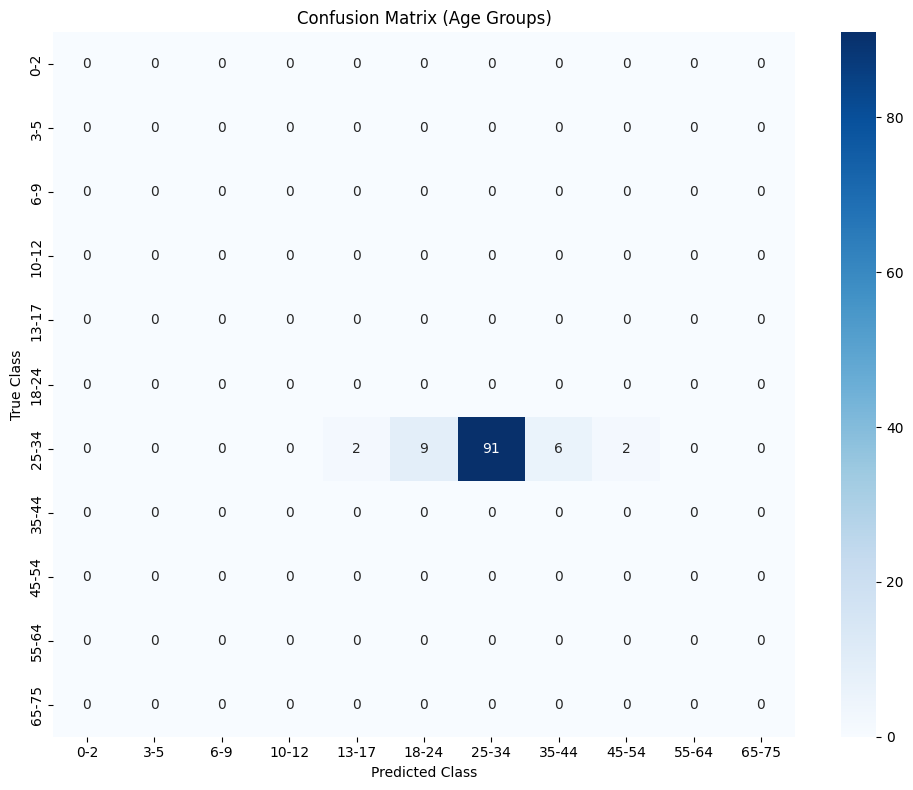

[26] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           4     0.0000    0.0000    0.0000         0
           5     0.0000    0.0000    0.0000         0
           6     1.0000    0.9068    0.9511       311
           7     0.0000    0.0000    0.0000         0
           8     0.0000    0.0000    0.0000         0

    accuracy                         0.9068       311
   macro avg     0.2000    0.1814    0.1902       311
weighted avg     1.0000    0.9068    0.9511       311


📉 Mean Absolute Error (MAE): 0.1061 (in age group units)


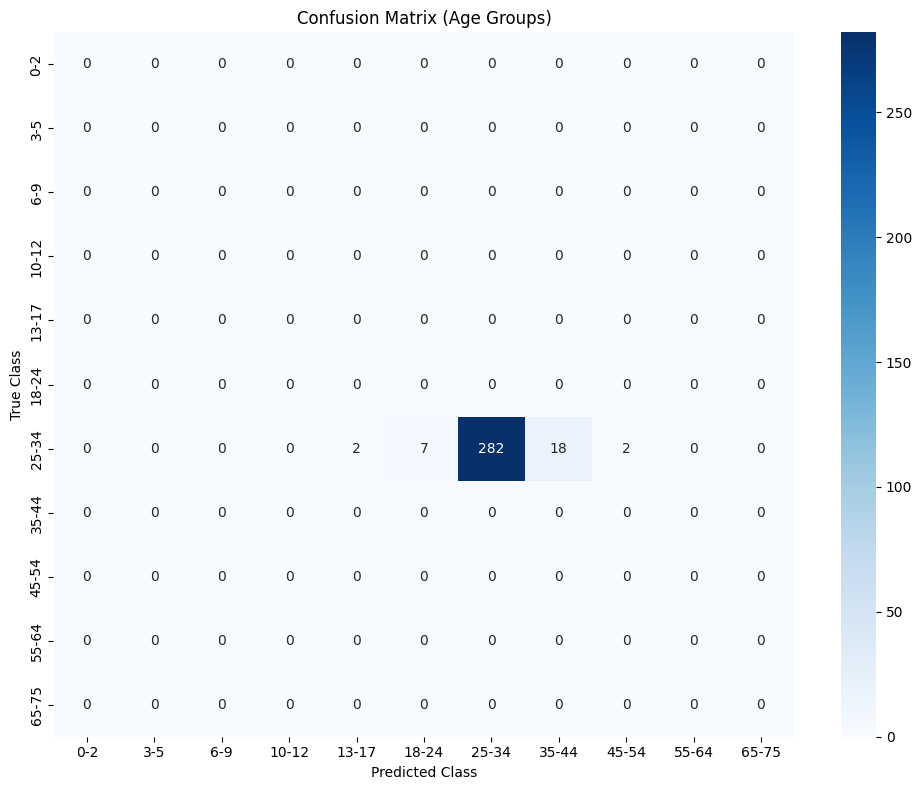

[27] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           5     0.0000    0.0000    0.0000         0
           6     1.0000    0.8478    0.9176        92
           7     0.0000    0.0000    0.0000         0
           8     0.0000    0.0000    0.0000         0

    accuracy                         0.8478        92
   macro avg     0.2500    0.2120    0.2294        92
weighted avg     1.0000    0.8478    0.9176        92


📉 Mean Absolute Error (MAE): 0.1630 (in age group units)


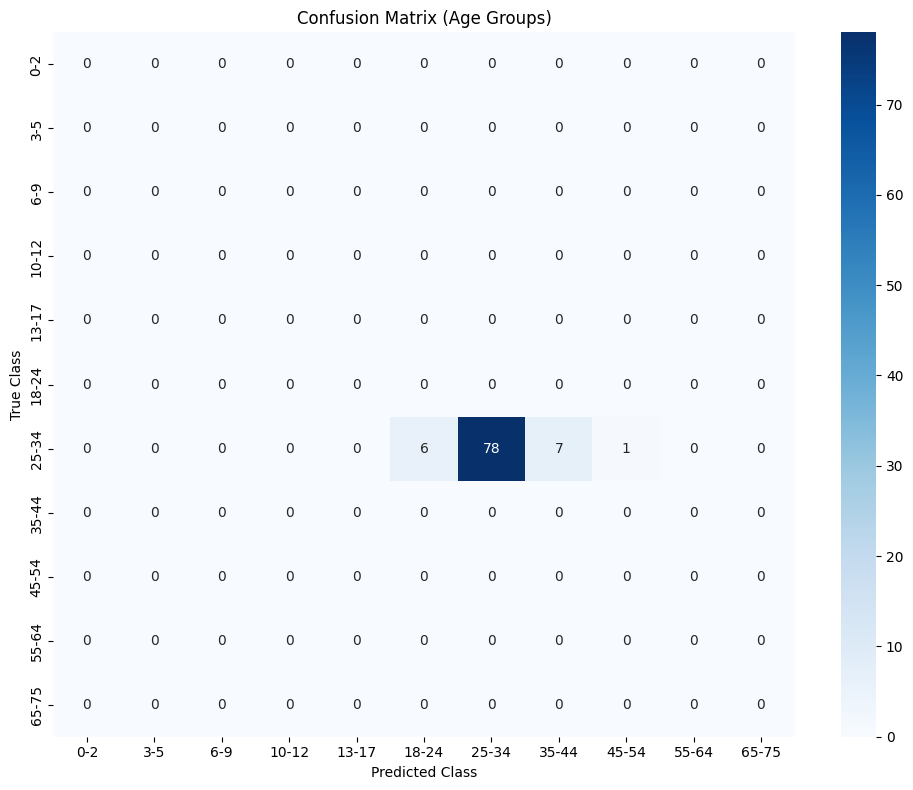

[28] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           5     0.0000    0.0000    0.0000         0
           6     1.0000    0.8841    0.9385       138
           7     0.0000    0.0000    0.0000         0

    accuracy                         0.8841       138
   macro avg     0.3333    0.2947    0.3128       138
weighted avg     1.0000    0.8841    0.9385       138


📉 Mean Absolute Error (MAE): 0.1159 (in age group units)


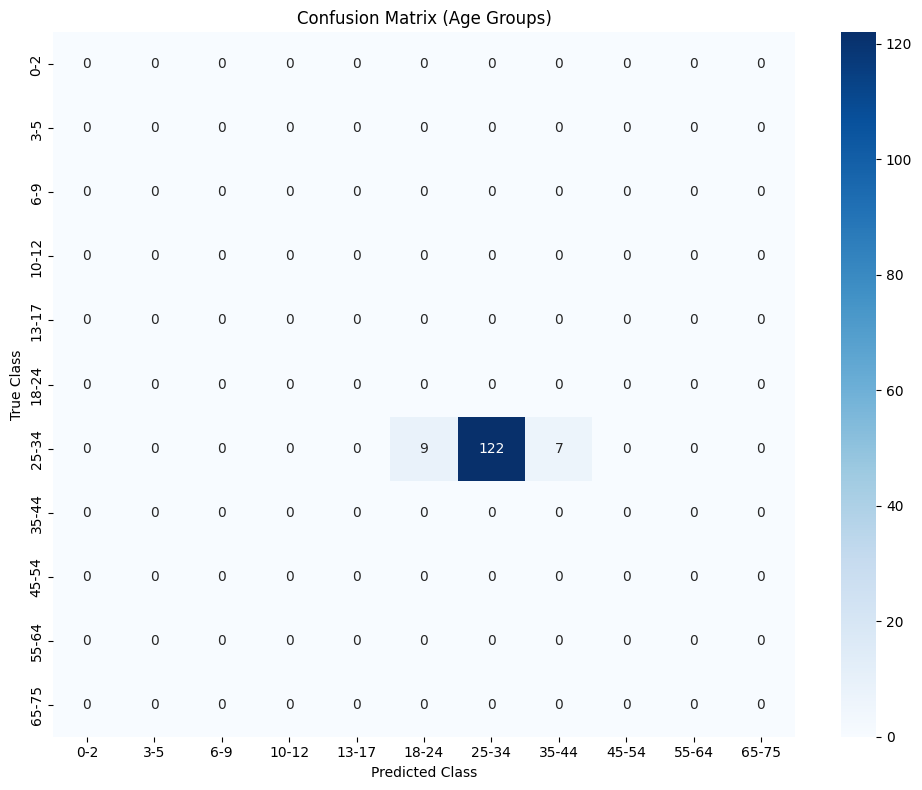

[29] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           5     0.0000    0.0000    0.0000         0
           6     1.0000    0.8519    0.9200        81
           7     0.0000    0.0000    0.0000         0
           9     0.0000    0.0000    0.0000         0

    accuracy                         0.8519        81
   macro avg     0.2500    0.2130    0.2300        81
weighted avg     1.0000    0.8519    0.9200        81


📉 Mean Absolute Error (MAE): 0.1728 (in age group units)


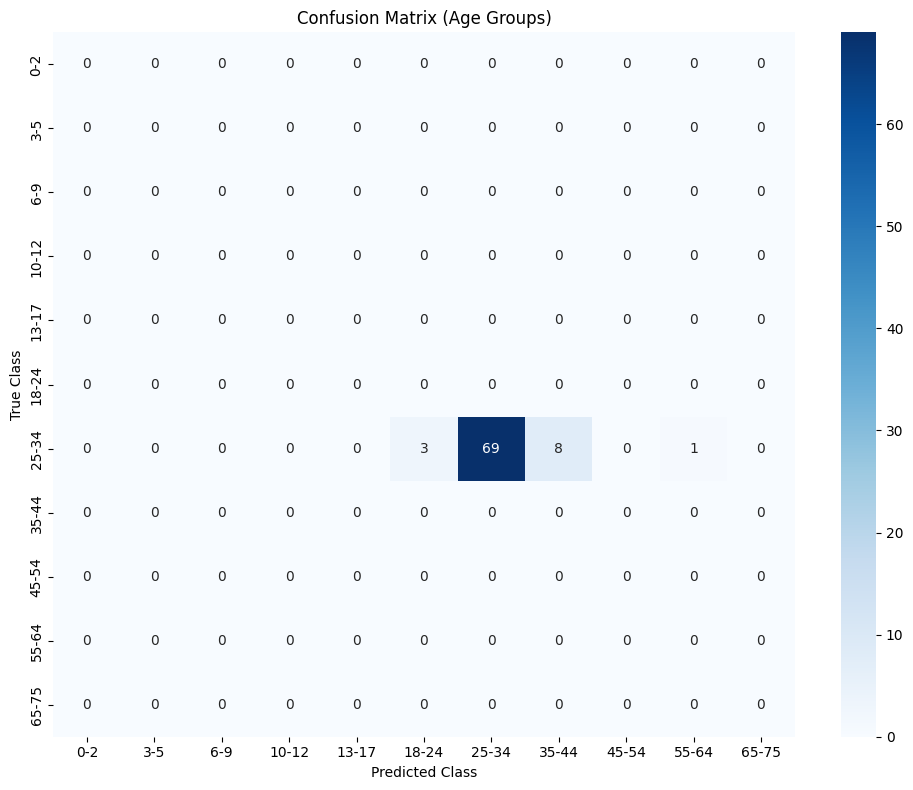

[30] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           4     0.0000    0.0000    0.0000         0
           5     0.0000    0.0000    0.0000         0
           6     1.0000    0.8974    0.9459       117
           7     0.0000    0.0000    0.0000         0
           8     0.0000    0.0000    0.0000         0

    accuracy                         0.8974       117
   macro avg     0.2000    0.1795    0.1892       117
weighted avg     1.0000    0.8974    0.9459       117


📉 Mean Absolute Error (MAE): 0.1282 (in age group units)


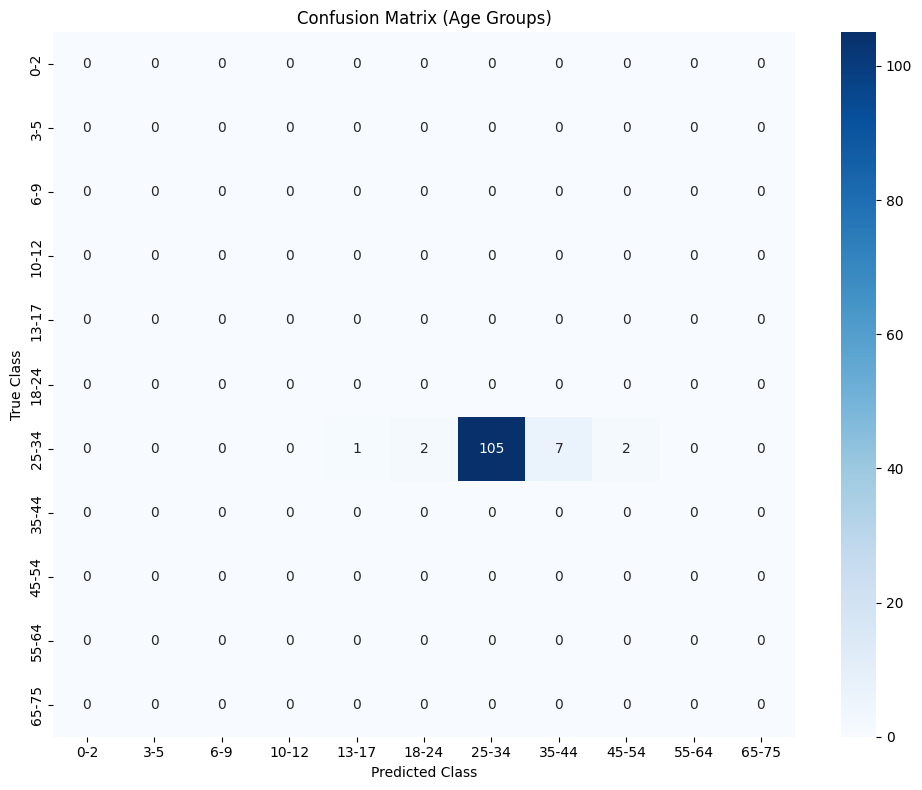

[31] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           5     0.0000    0.0000    0.0000         0
           6     1.0000    0.7358    0.8478        53
           7     0.0000    0.0000    0.0000         0
           8     0.0000    0.0000    0.0000         0

    accuracy                         0.7358        53
   macro avg     0.2500    0.1840    0.2120        53
weighted avg     1.0000    0.7358    0.8478        53


📉 Mean Absolute Error (MAE): 0.2830 (in age group units)


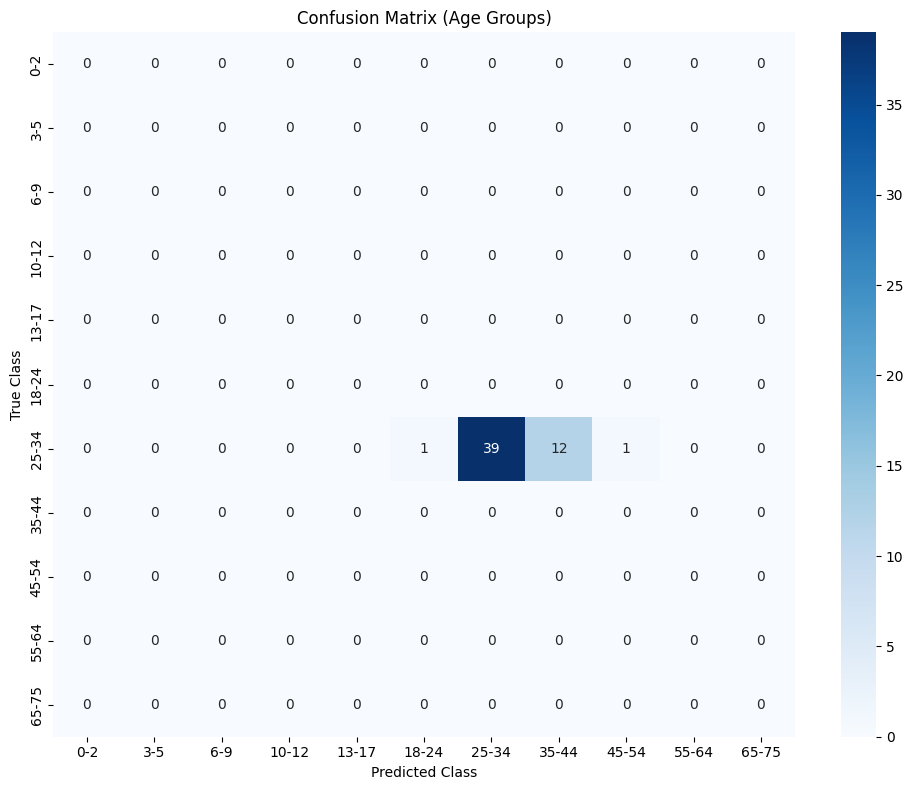

[32] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           6     1.0000    0.7857    0.8800        98
           7     0.0000    0.0000    0.0000         0
           8     0.0000    0.0000    0.0000         0

    accuracy                         0.7857        98
   macro avg     0.3333    0.2619    0.2933        98
weighted avg     1.0000    0.7857    0.8800        98


📉 Mean Absolute Error (MAE): 0.2653 (in age group units)


[33] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           6     1.0000    0.7931    0.8846        29
           7     0.0000    0.0000    0.0000         0
           8     0.0000    0.0000    0.0000         0

    accuracy                         0.7931        29
   macro avg     0.3333    0.2644    0.2949        29
weighted avg     1.0000    0.7931    0.8846        29


📉 Mean Absolute Error (MAE): 0.2414 (in age group units)


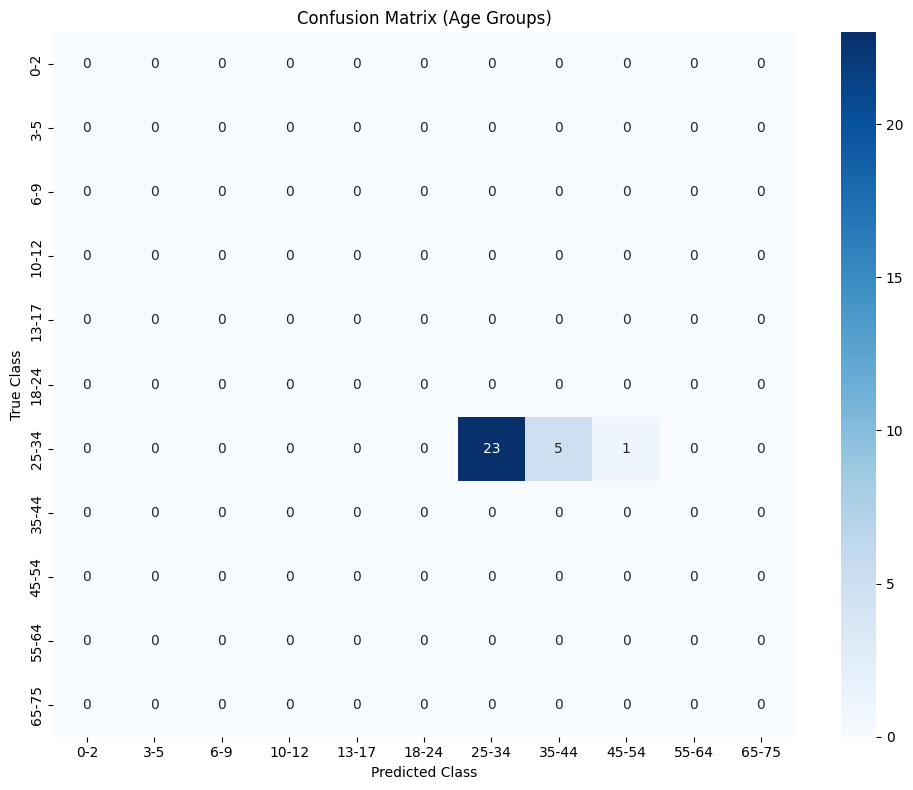

[34] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           4     0.0000    0.0000    0.0000         0
           6     1.0000    0.6849    0.8130        73
           7     0.0000    0.0000    0.0000         0
           8     0.0000    0.0000    0.0000         0

    accuracy                         0.6849        73
   macro avg     0.2500    0.1712    0.2033        73
weighted avg     1.0000    0.6849    0.8130        73


📉 Mean Absolute Error (MAE): 0.3973 (in age group units)


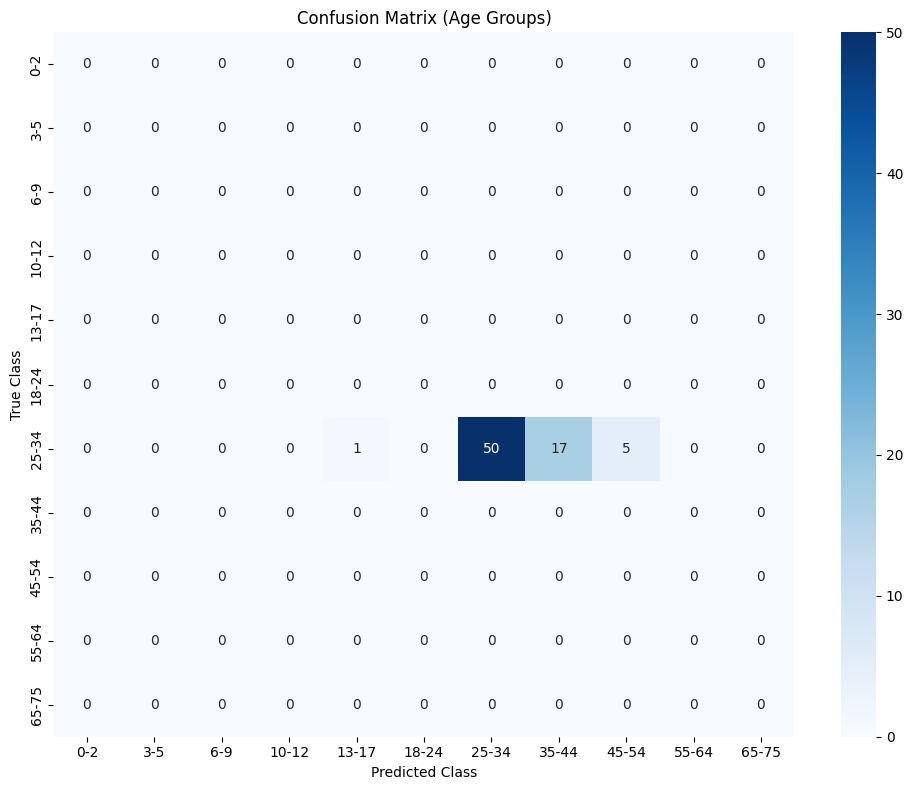

In [ ]:

SELECTED_AGES =[25]
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

SELECTED_AGES =[26]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)


SELECTED_AGES =[27]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)


SELECTED_AGES =[28]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)


SELECTED_AGES =[29]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

SELECTED_AGES =[30]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)


SELECTED_AGES =[31]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

SELECTED_AGES =[32]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)


SELECTED_AGES =[33]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

SELECTED_AGES =[34]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

### (35-44)

[35] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           4     0.0000    0.0000    0.0000         0
           6     0.0000    0.0000    0.0000         0
           7     1.0000    0.3358    0.5027       137
           8     0.0000    0.0000    0.0000         0
           9     0.0000    0.0000    0.0000         0

    accuracy                         0.3358       137
   macro avg     0.2000    0.0672    0.1005       137
weighted avg     1.0000    0.3358    0.5027       137


📉 Mean Absolute Error (MAE): 0.7007 (in age group units)


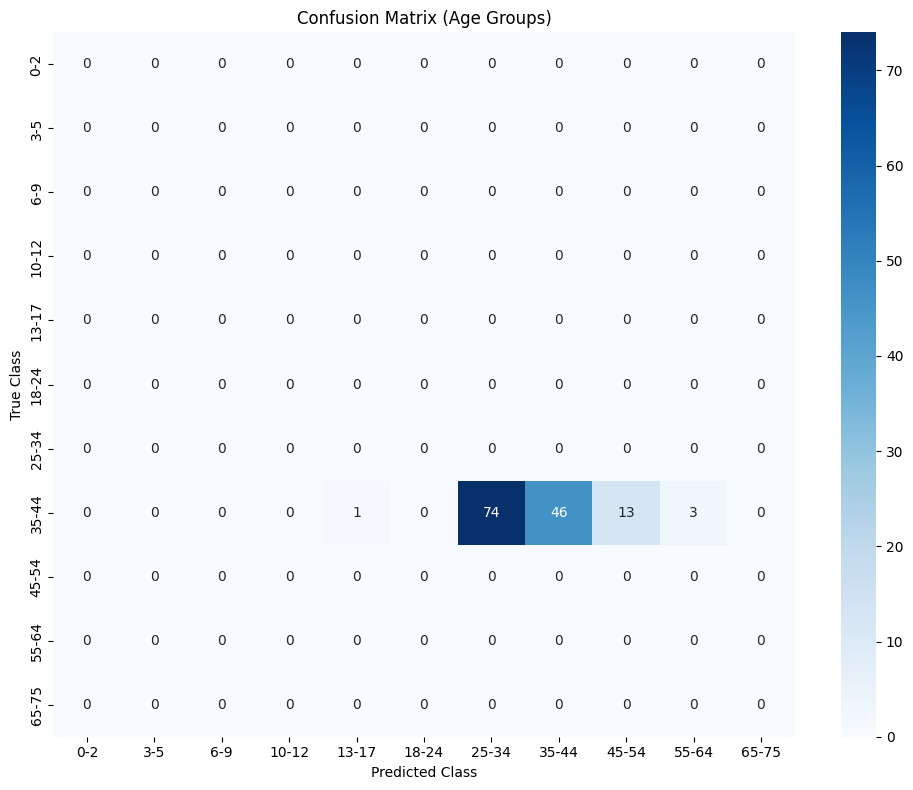

[36] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           6     0.0000    0.0000    0.0000         0
           7     1.0000    0.4648    0.6346        71
           8     0.0000    0.0000    0.0000         0

    accuracy                         0.4648        71
   macro avg     0.3333    0.1549    0.2115        71
weighted avg     1.0000    0.4648    0.6346        71


📉 Mean Absolute Error (MAE): 0.5352 (in age group units)


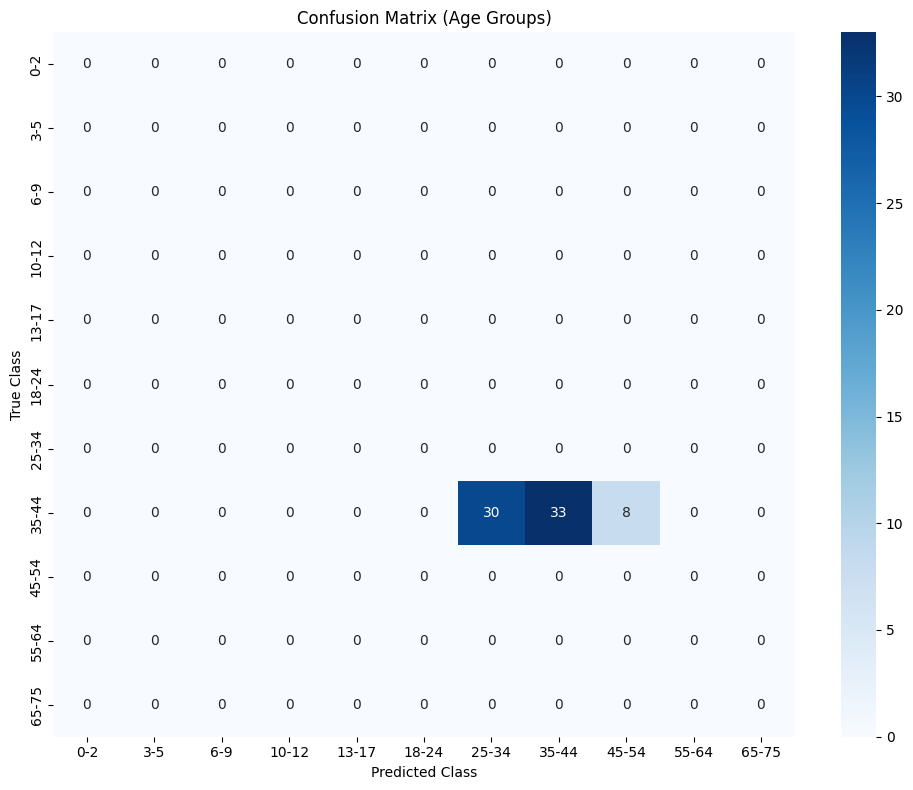

[37] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           6     0.0000    0.0000    0.0000         0
           7     1.0000    0.4186    0.5902        43
           8     0.0000    0.0000    0.0000         0

    accuracy                         0.4186        43
   macro avg     0.3333    0.1395    0.1967        43
weighted avg     1.0000    0.4186    0.5902        43


📉 Mean Absolute Error (MAE): 0.5814 (in age group units)


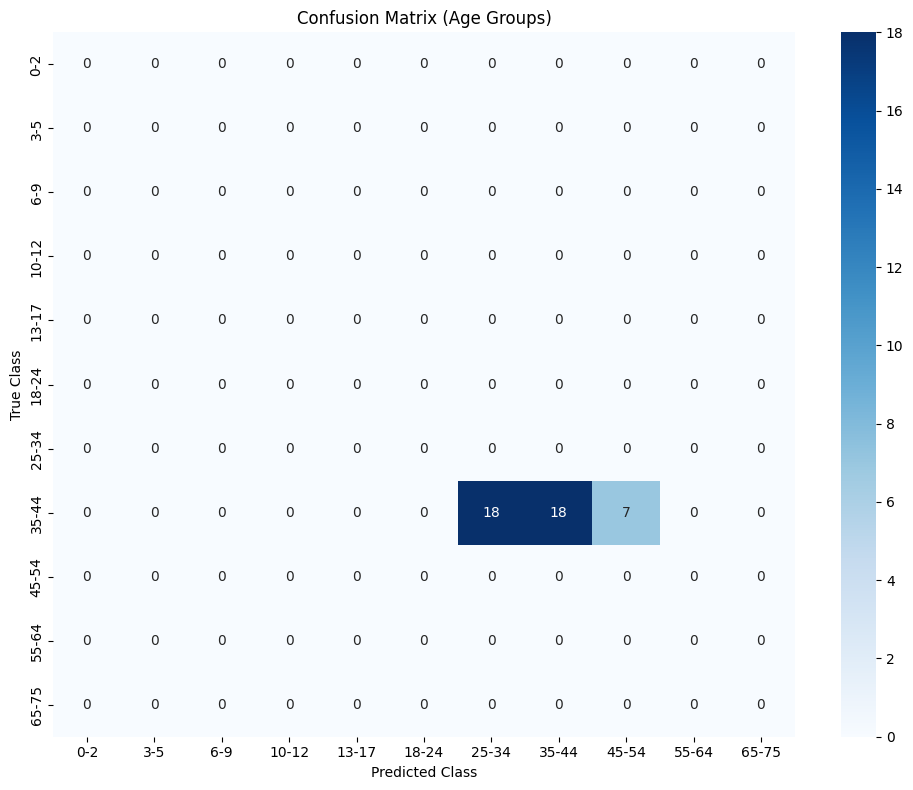

[38] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           6     0.0000    0.0000    0.0000         0
           7     1.0000    0.4348    0.6061        46
           8     0.0000    0.0000    0.0000         0
           9     0.0000    0.0000    0.0000         0

    accuracy                         0.4348        46
   macro avg     0.2500    0.1087    0.1515        46
weighted avg     1.0000    0.4348    0.6061        46


📉 Mean Absolute Error (MAE): 0.5870 (in age group units)


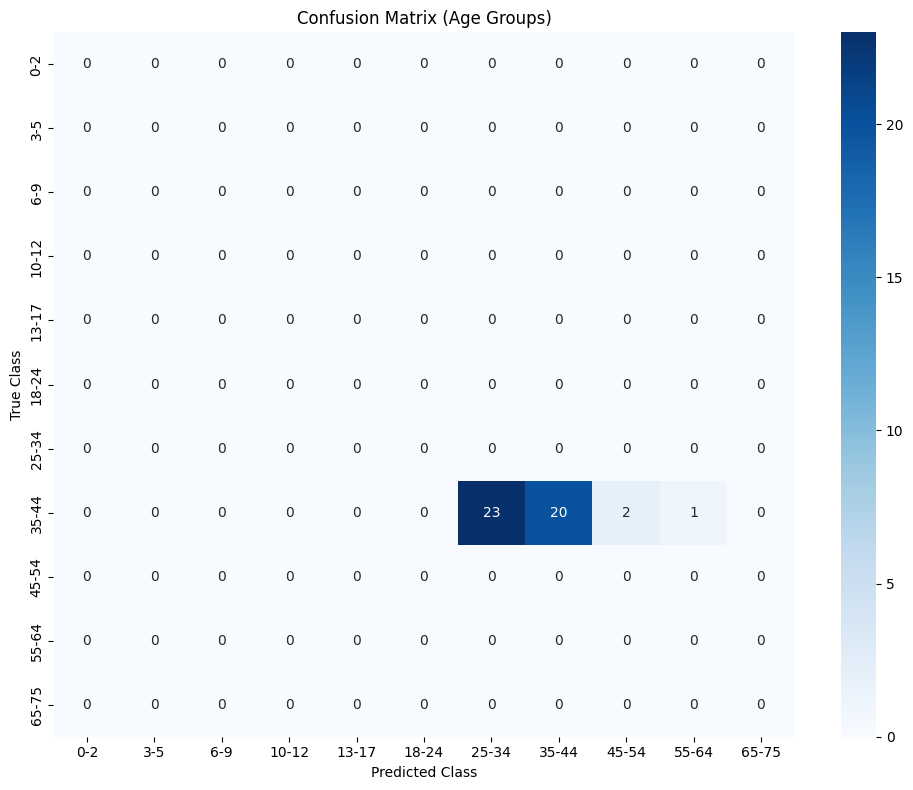

[39] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           5     0.0000    0.0000    0.0000         0
           6     0.0000    0.0000    0.0000         0
           7     1.0000    0.3000    0.4615        30
           8     0.0000    0.0000    0.0000         0

    accuracy                         0.3000        30
   macro avg     0.2500    0.0750    0.1154        30
weighted avg     1.0000    0.3000    0.4615        30


📉 Mean Absolute Error (MAE): 0.7333 (in age group units)


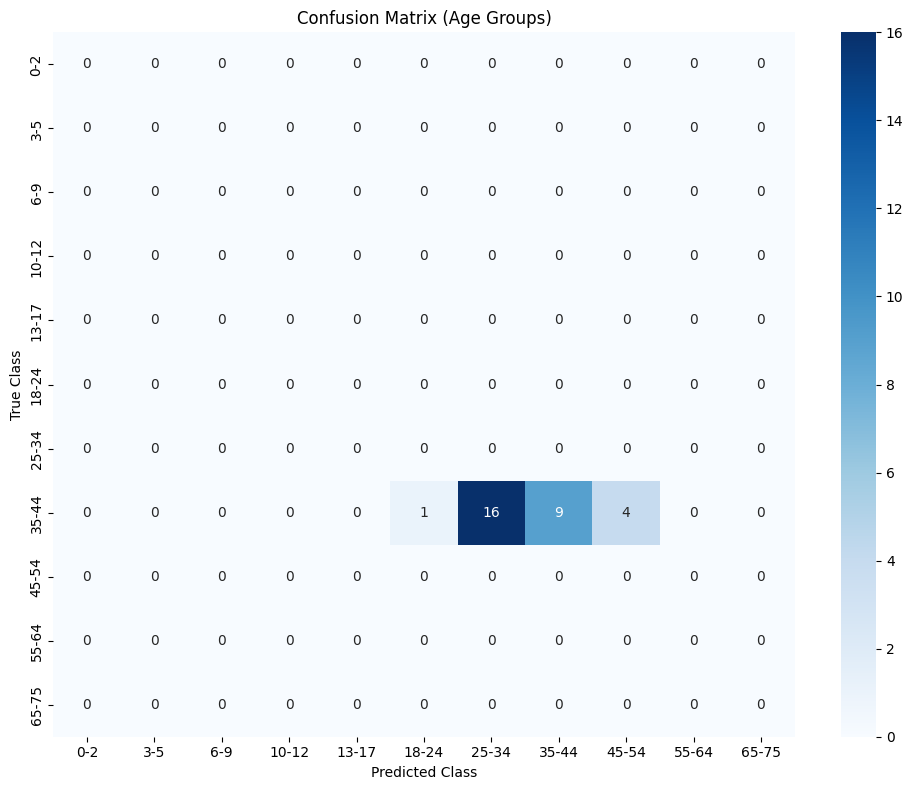

[40] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           6     0.0000    0.0000    0.0000         0
           7     1.0000    0.5385    0.7000        65
           8     0.0000    0.0000    0.0000         0
           9     0.0000    0.0000    0.0000         0

    accuracy                         0.5385        65
   macro avg     0.2500    0.1346    0.1750        65
weighted avg     1.0000    0.5385    0.7000        65


📉 Mean Absolute Error (MAE): 0.4923 (in age group units)


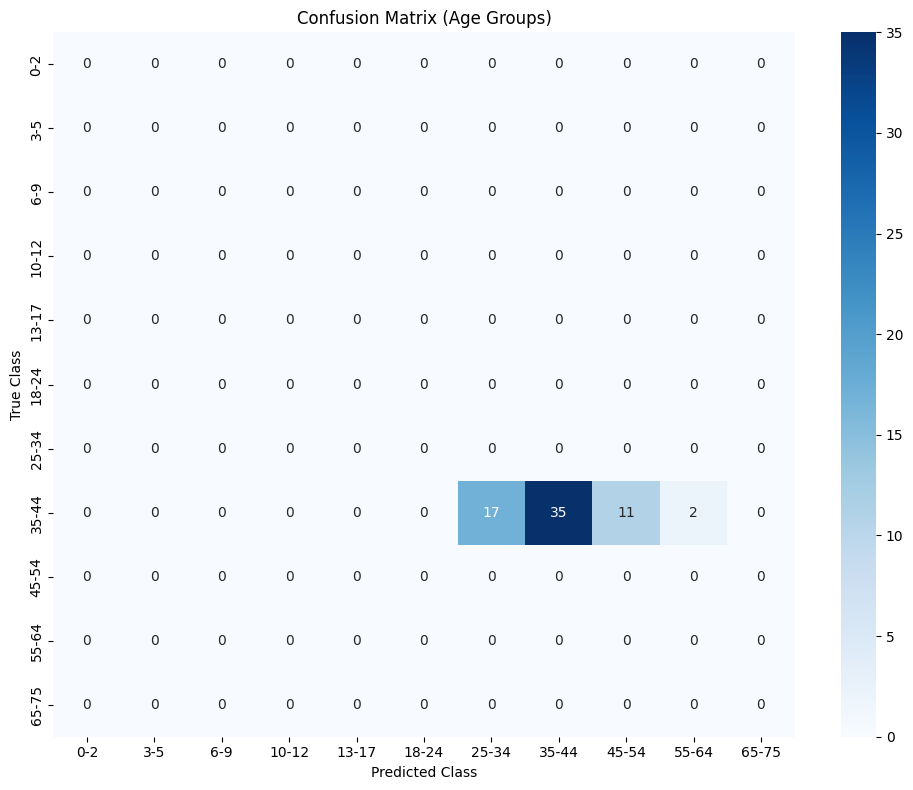

[41] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           6     0.0000    0.0000    0.0000         0
           7     1.0000    0.5238    0.6875        21
           8     0.0000    0.0000    0.0000         0

    accuracy                         0.5238        21
   macro avg     0.3333    0.1746    0.2292        21
weighted avg     1.0000    0.5238    0.6875        21


📉 Mean Absolute Error (MAE): 0.4762 (in age group units)


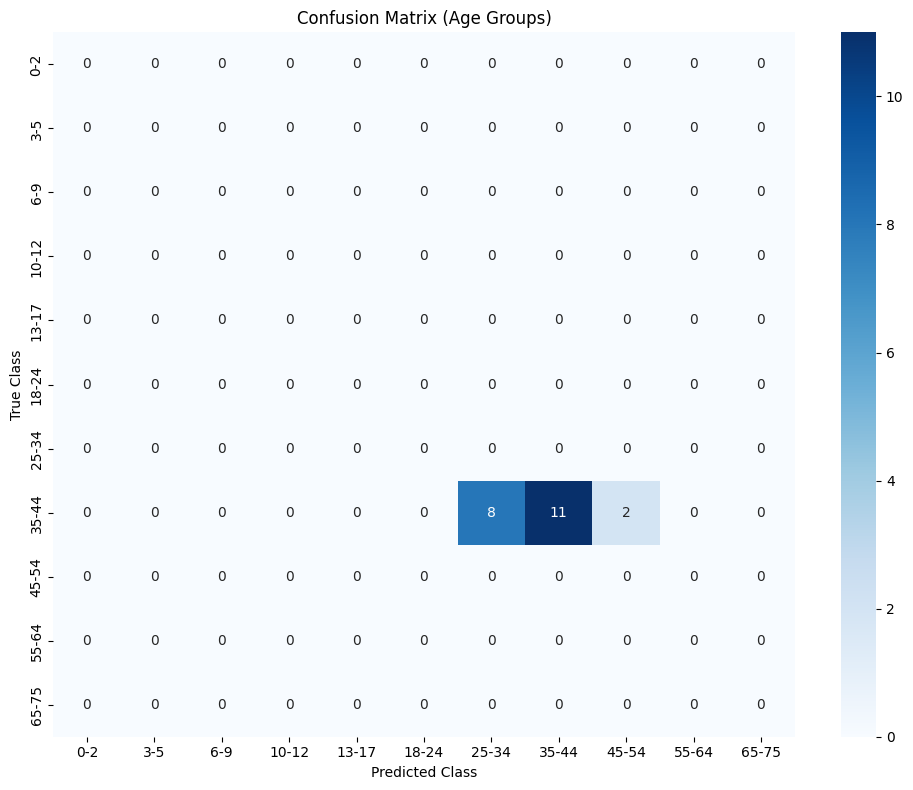

[42] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           6     0.0000    0.0000    0.0000         0
           7     1.0000    0.4242    0.5957        33
           8     0.0000    0.0000    0.0000         0
           9     0.0000    0.0000    0.0000         0

    accuracy                         0.4242        33
   macro avg     0.2500    0.1061    0.1489        33
weighted avg     1.0000    0.4242    0.5957        33


📉 Mean Absolute Error (MAE): 0.6364 (in age group units)


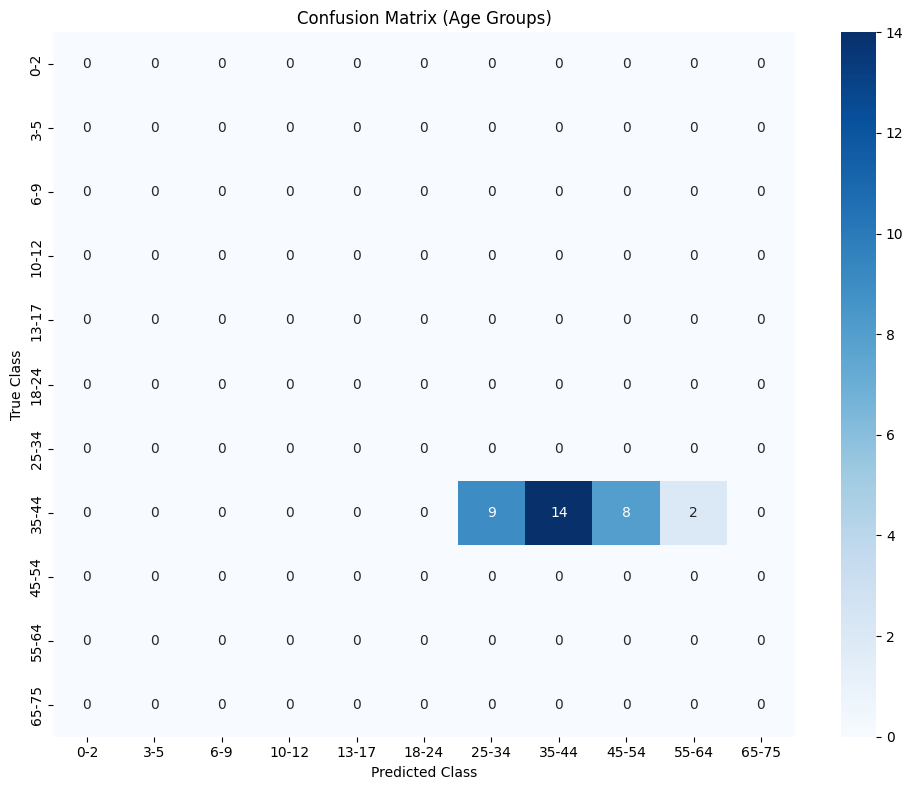

[43] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           6     0.0000    0.0000    0.0000         0
           7     1.0000    0.3462    0.5143        26
           8     0.0000    0.0000    0.0000         0
           9     0.0000    0.0000    0.0000         0

    accuracy                         0.3462        26
   macro avg     0.2500    0.0865    0.1286        26
weighted avg     1.0000    0.3462    0.5143        26


📉 Mean Absolute Error (MAE): 0.8462 (in age group units)


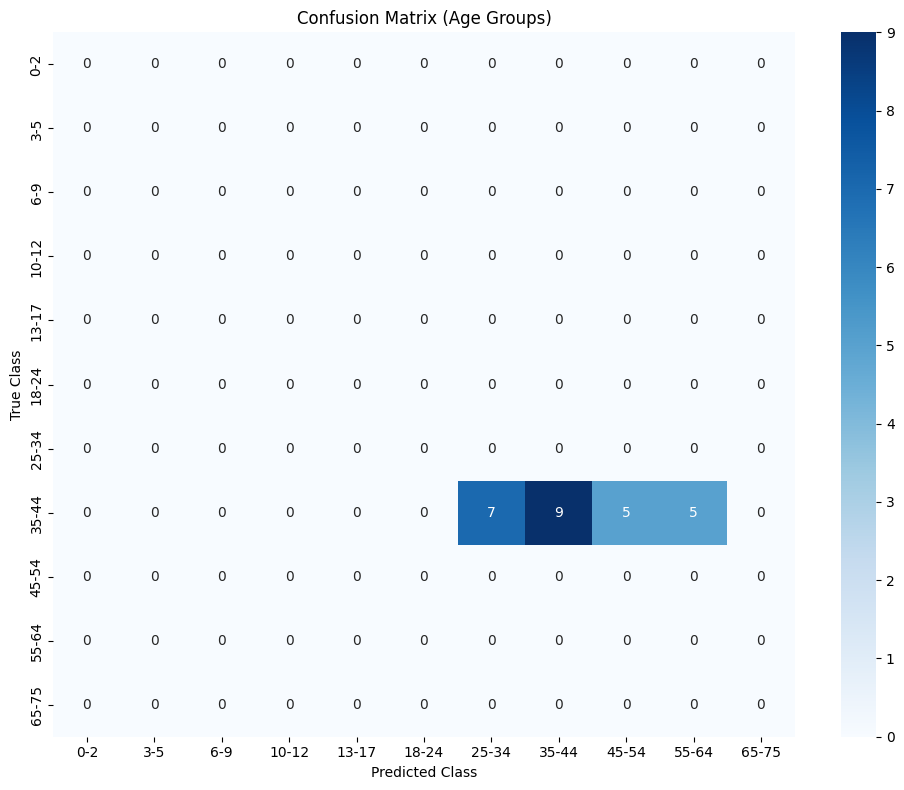

[44] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           6     0.0000    0.0000    0.0000         0
           7     1.0000    0.5000    0.6667        12
           8     0.0000    0.0000    0.0000         0
           9     0.0000    0.0000    0.0000         0

    accuracy                         0.5000        12
   macro avg     0.2500    0.1250    0.1667        12
weighted avg     1.0000    0.5000    0.6667        12


📉 Mean Absolute Error (MAE): 0.5833 (in age group units)


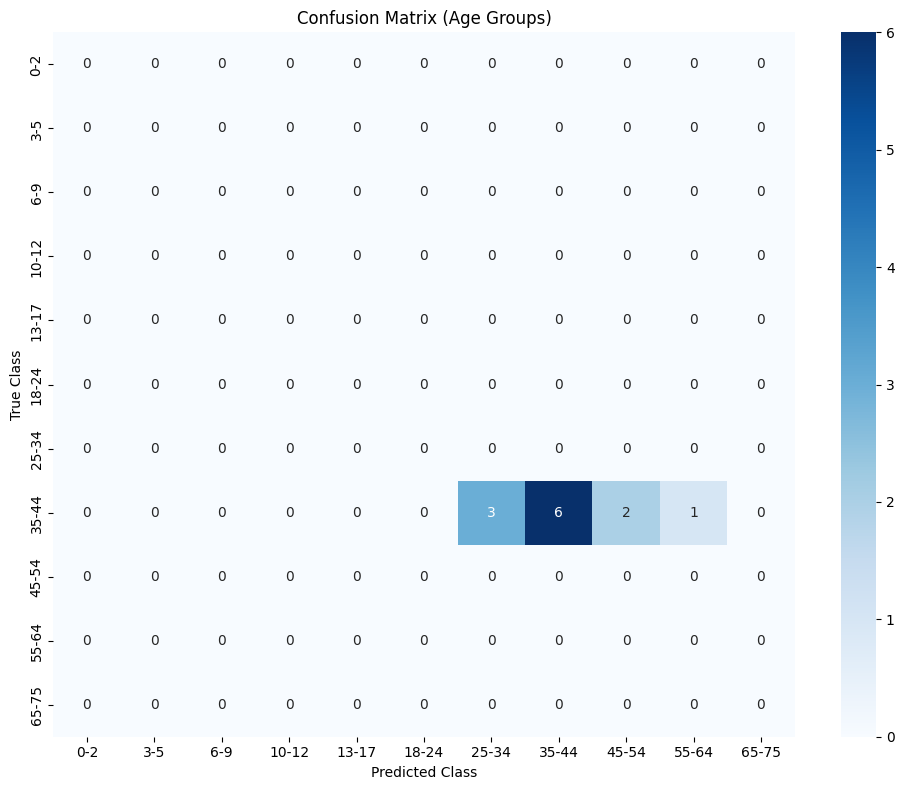

In [ ]:

SELECTED_AGES =[35]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)


SELECTED_AGES =[36]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

SELECTED_AGES =[37]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)


SELECTED_AGES =[38]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

SELECTED_AGES =[39]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

SELECTED_AGES =[40]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)


SELECTED_AGES =[41]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

SELECTED_AGES =[42]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)


SELECTED_AGES =[43]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

SELECTED_AGES =[44]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

### (35-39) (40-44) like this gives more information

[35, 36, 37, 38, 39] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           4     0.0000    0.0000    0.0000         0
           5     0.0000    0.0000    0.0000         0
           6     0.0000    0.0000    0.0000         0
           7     1.0000    0.3853    0.5563       327
           8     0.0000    0.0000    0.0000         0
           9     0.0000    0.0000    0.0000         0

    accuracy                         0.3853       327
   macro avg     0.1667    0.0642    0.0927       327
weighted avg     1.0000    0.3853    0.5563       327


📉 Mean Absolute Error (MAE): 0.6361 (in age group units)


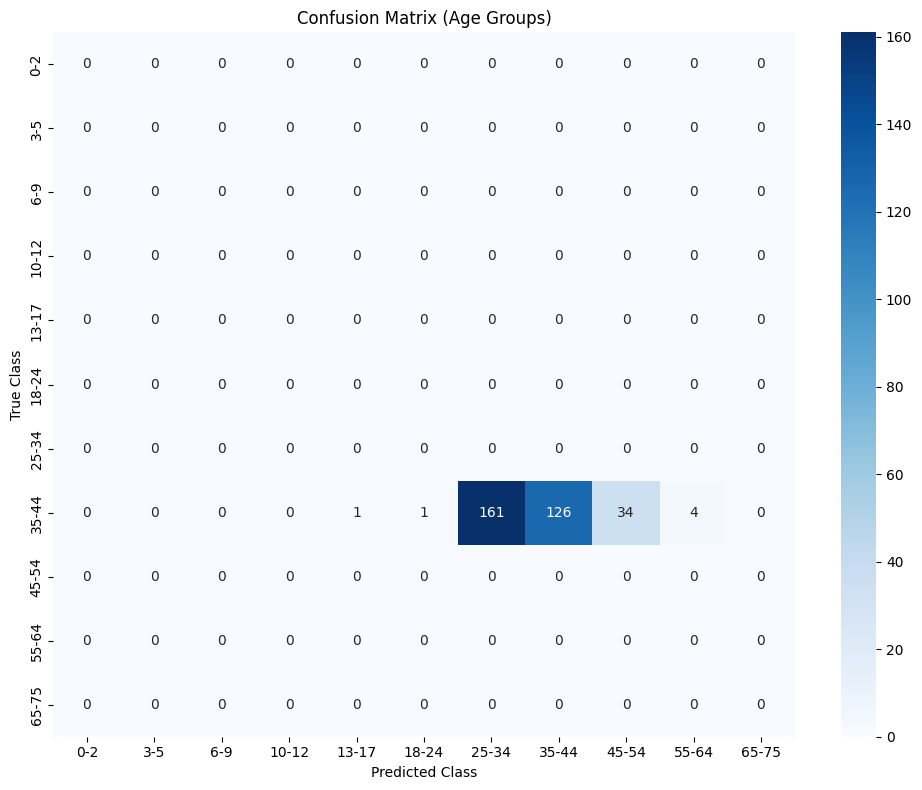

[40, 41, 42, 43, 44] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           6     0.0000    0.0000    0.0000         0
           7     1.0000    0.4777    0.6466       157
           8     0.0000    0.0000    0.0000         0
           9     0.0000    0.0000    0.0000         0

    accuracy                         0.4777       157
   macro avg     0.2500    0.1194    0.1616       157
weighted avg     1.0000    0.4777    0.6466       157


📉 Mean Absolute Error (MAE): 0.5860 (in age group units)


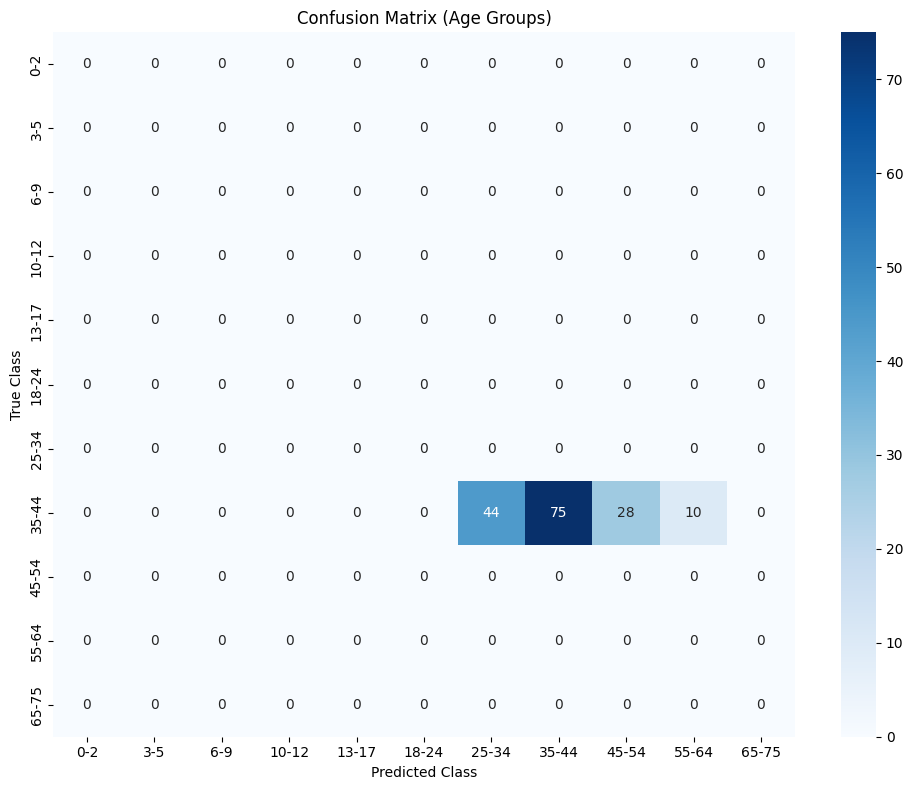

In [ ]:

SELECTED_AGES =[35,36,37,38,39]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

SELECTED_AGES =[40,41,42,43,44]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)


### (45-54)

[45] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           6     0.0000    0.0000    0.0000         0
           7     0.0000    0.0000    0.0000         0
           8     1.0000    0.6066    0.7551        61
           9     0.0000    0.0000    0.0000         0

    accuracy                         0.6066        61
   macro avg     0.2500    0.1516    0.1888        61
weighted avg     1.0000    0.6066    0.7551        61


📉 Mean Absolute Error (MAE): 0.5246 (in age group units)


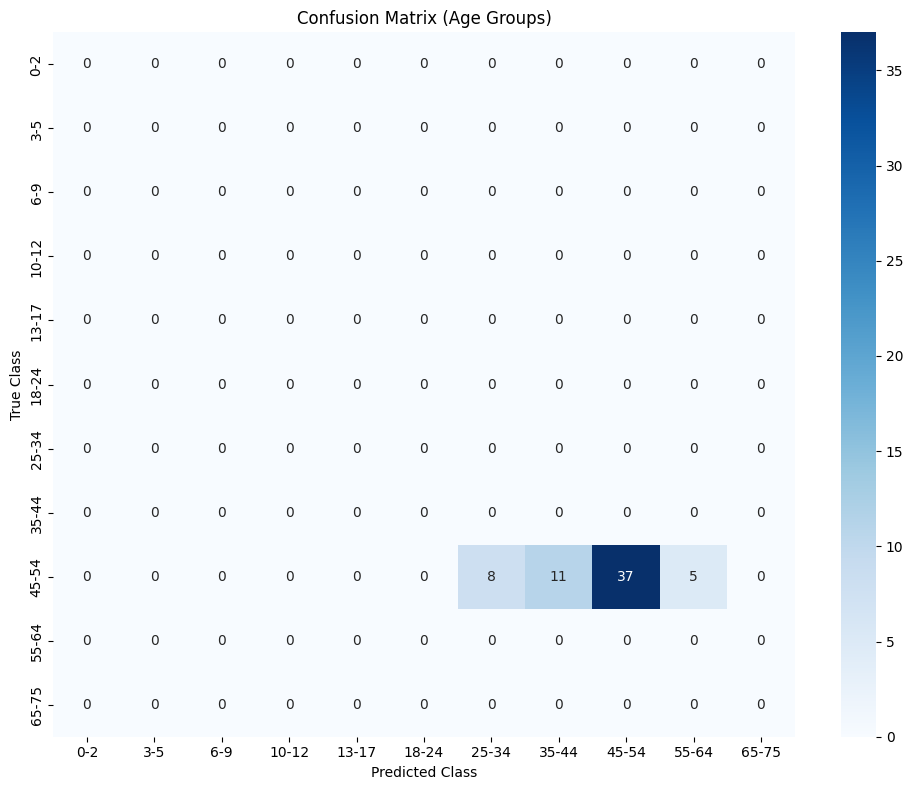

[46] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           6     0.0000    0.0000    0.0000         0
           7     0.0000    0.0000    0.0000         0
           8     1.0000    0.4615    0.6316        26
          10     0.0000    0.0000    0.0000         0

    accuracy                         0.4615        26
   macro avg     0.2500    0.1154    0.1579        26
weighted avg     1.0000    0.4615    0.6316        26


📉 Mean Absolute Error (MAE): 0.6923 (in age group units)


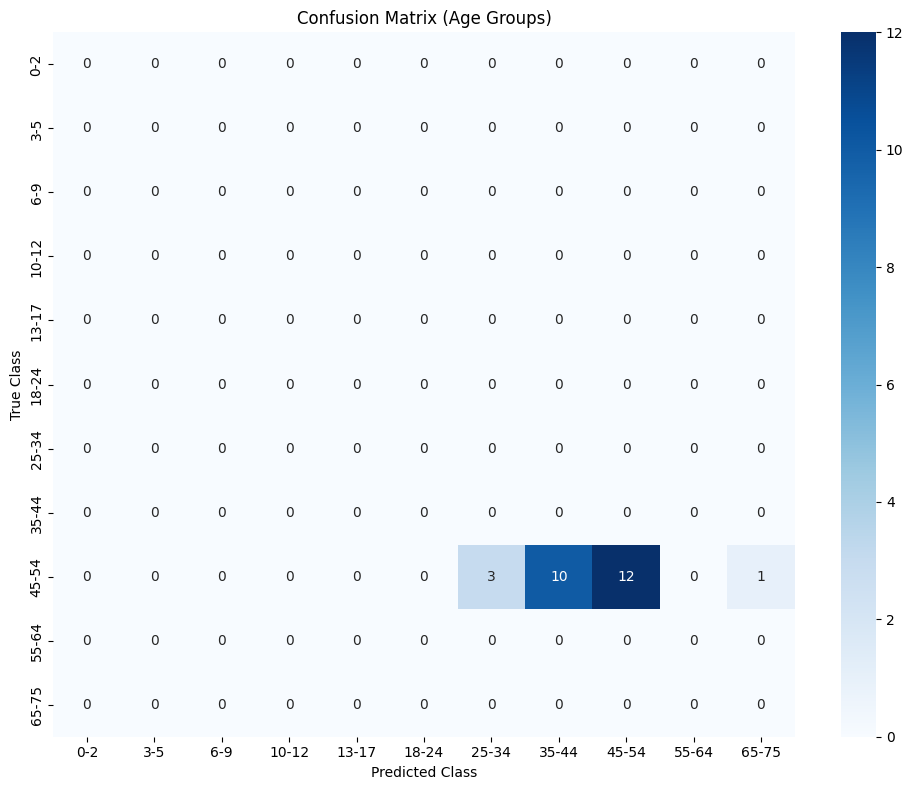

[47] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           6     0.0000    0.0000    0.0000         0
           7     0.0000    0.0000    0.0000         0
           8     1.0000    0.4231    0.5946        26
           9     0.0000    0.0000    0.0000         0

    accuracy                         0.4231        26
   macro avg     0.2500    0.1058    0.1486        26
weighted avg     1.0000    0.4231    0.5946        26


📉 Mean Absolute Error (MAE): 0.7308 (in age group units)


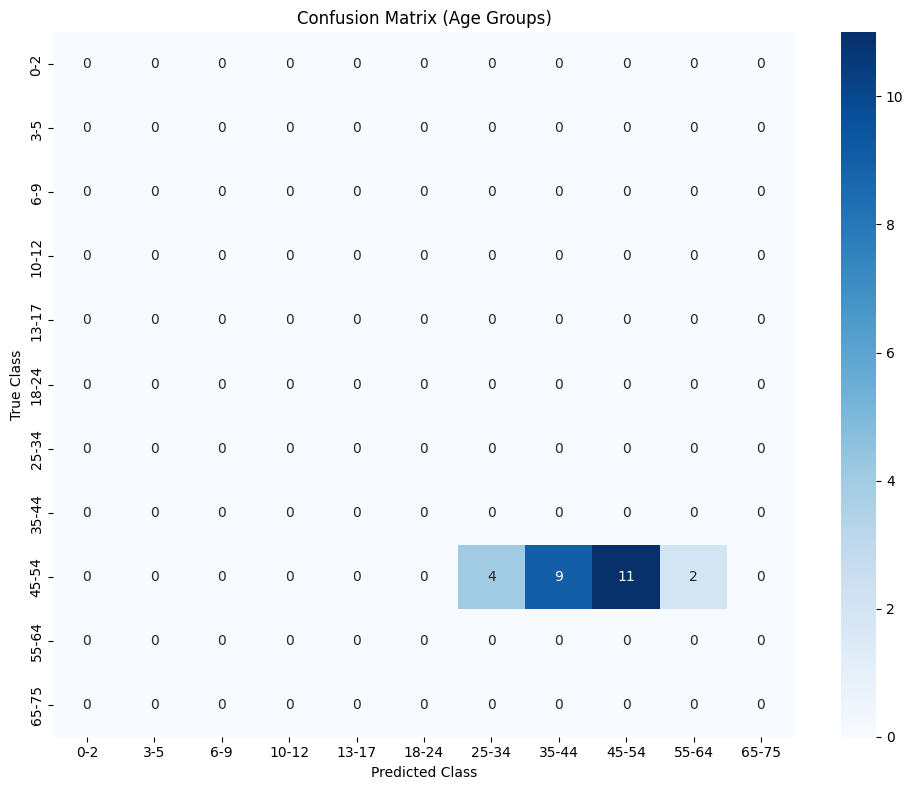

[48] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           6     0.0000    0.0000    0.0000         0
           7     0.0000    0.0000    0.0000         0
           8     1.0000    0.5500    0.7097        20
           9     0.0000    0.0000    0.0000         0

    accuracy                         0.5500        20
   macro avg     0.2500    0.1375    0.1774        20
weighted avg     1.0000    0.5500    0.7097        20


📉 Mean Absolute Error (MAE): 0.6500 (in age group units)


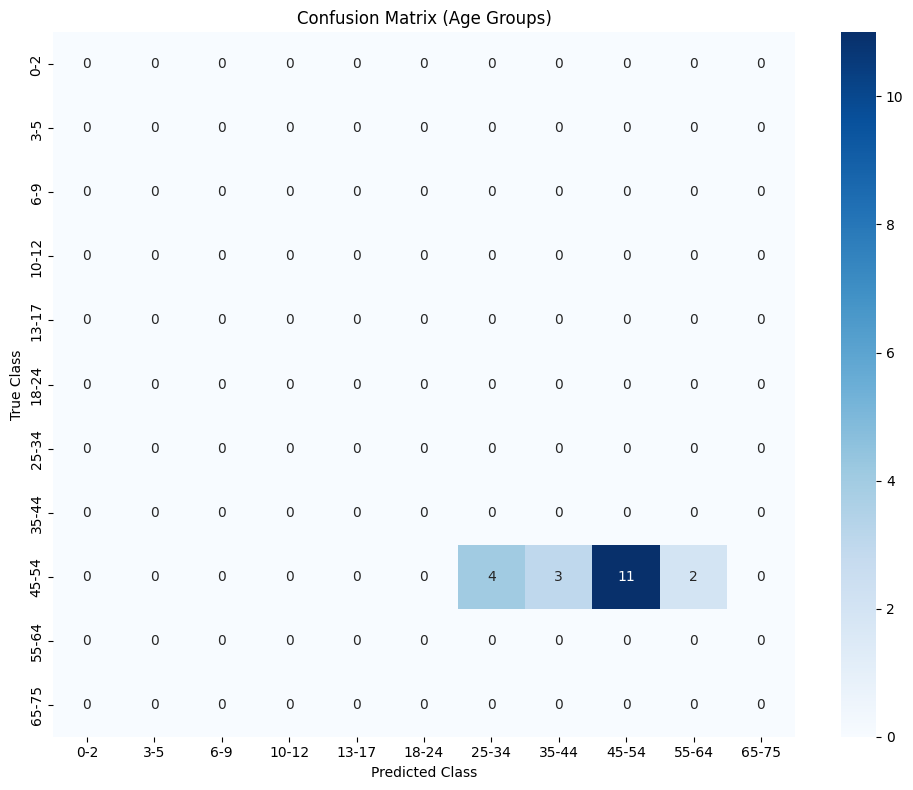

[49] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           6     0.0000    0.0000    0.0000         0
           7     0.0000    0.0000    0.0000         0
           8     1.0000    0.3077    0.4706        26
           9     0.0000    0.0000    0.0000         0

    accuracy                         0.3077        26
   macro avg     0.2500    0.0769    0.1176        26
weighted avg     1.0000    0.3077    0.4706        26


📉 Mean Absolute Error (MAE): 0.8846 (in age group units)


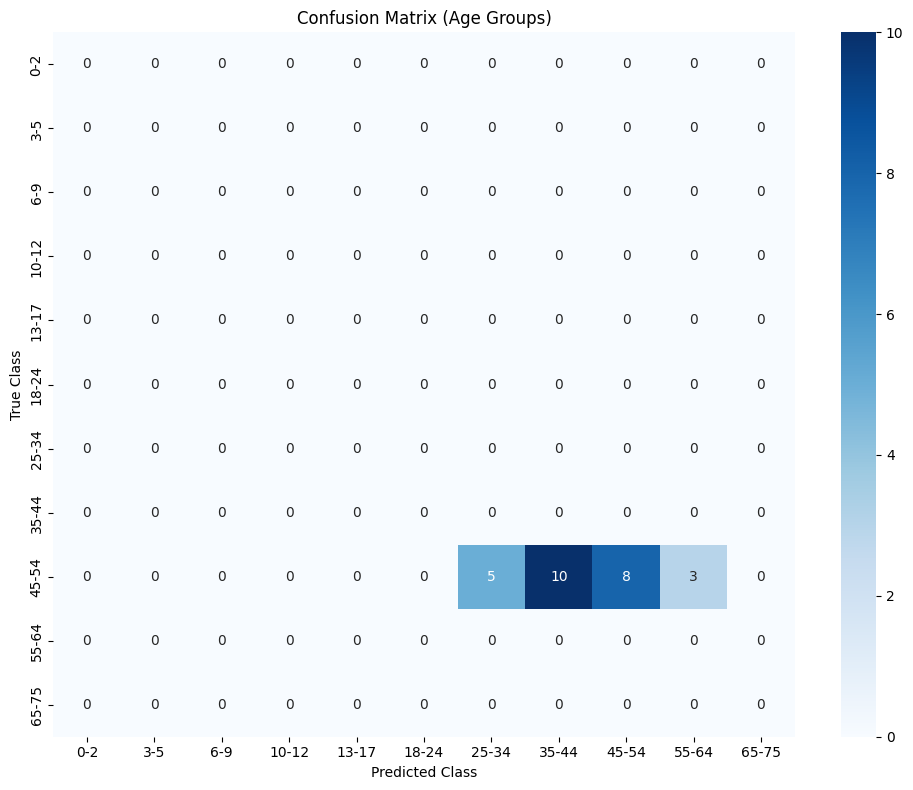

[50] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           6     0.0000    0.0000    0.0000         0
           7     0.0000    0.0000    0.0000         0
           8     1.0000    0.5161    0.6809        62
           9     0.0000    0.0000    0.0000         0

    accuracy                         0.5161        62
   macro avg     0.2500    0.1290    0.1702        62
weighted avg     1.0000    0.5161    0.6809        62


📉 Mean Absolute Error (MAE): 0.5161 (in age group units)


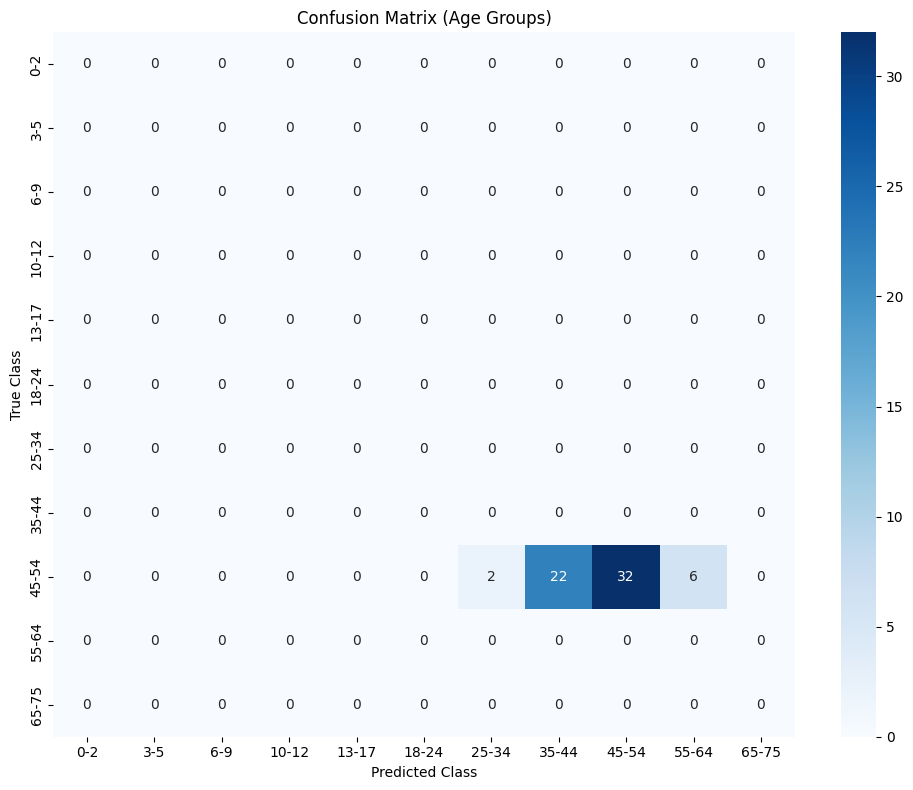

[51] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           6     0.0000    0.0000    0.0000         0
           7     0.0000    0.0000    0.0000         0
           8     1.0000    0.4737    0.6429        19
           9     0.0000    0.0000    0.0000         0

    accuracy                         0.4737        19
   macro avg     0.2500    0.1184    0.1607        19
weighted avg     1.0000    0.4737    0.6429        19


📉 Mean Absolute Error (MAE): 0.6316 (in age group units)


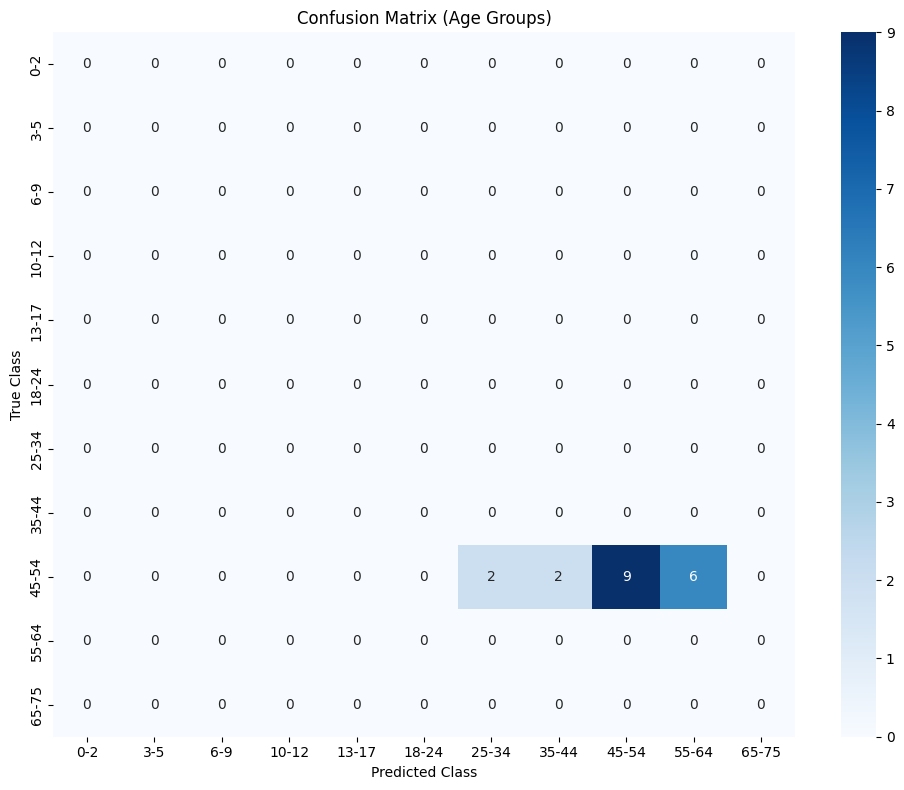

[52] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           6     0.0000    0.0000    0.0000         0
           7     0.0000    0.0000    0.0000         0
           8     1.0000    0.5952    0.7463        42
           9     0.0000    0.0000    0.0000         0
          10     0.0000    0.0000    0.0000         0

    accuracy                         0.5952        42
   macro avg     0.2000    0.1190    0.1493        42
weighted avg     1.0000    0.5952    0.7463        42


📉 Mean Absolute Error (MAE): 0.5238 (in age group units)


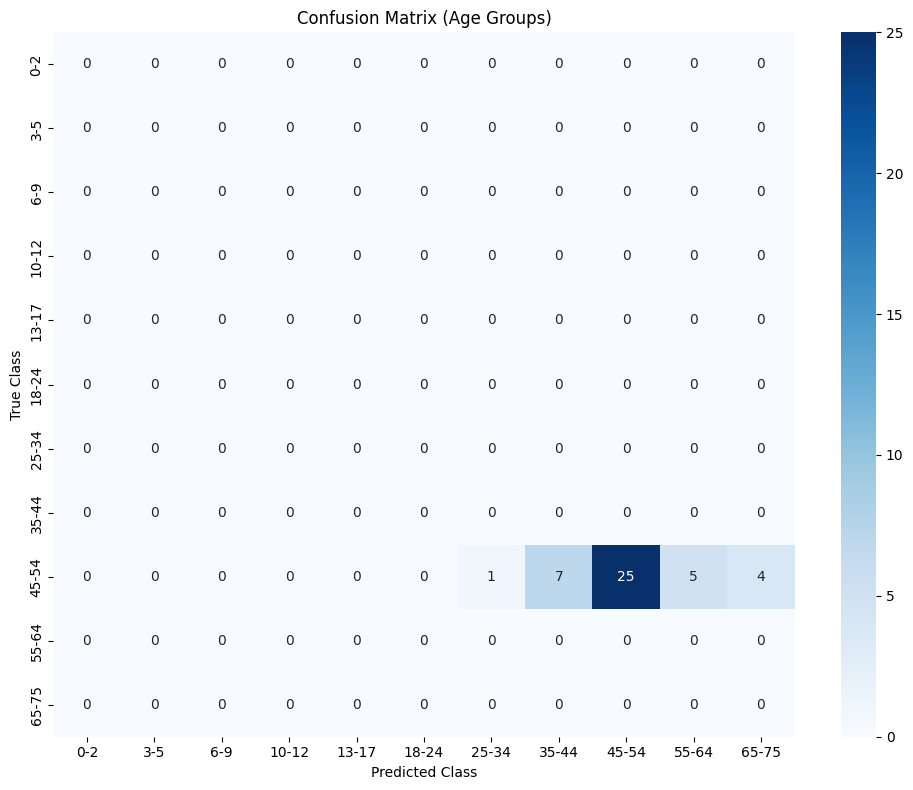

[53] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           6     0.0000    0.0000    0.0000         0
           7     0.0000    0.0000    0.0000         0
           8     1.0000    0.4634    0.6333        41
           9     0.0000    0.0000    0.0000         0
          10     0.0000    0.0000    0.0000         0

    accuracy                         0.4634        41
   macro avg     0.2000    0.0927    0.1267        41
weighted avg     1.0000    0.4634    0.6333        41


📉 Mean Absolute Error (MAE): 0.6585 (in age group units)


[54] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           6     0.0000    0.0000    0.0000         0
           7     0.0000    0.0000    0.0000         0
           8     1.0000    0.5490    0.7089        51
           9     0.0000    0.0000    0.0000         0
          10     0.0000    0.0000    0.0000         0

    accuracy                         0.5490        51
   macro avg     0.2000    0.1098    0.1418        51
weighted avg     1.0000    0.5490    0.7089        51


📉 Mean Absolute Error (MAE): 0.5686 (in age group units)


In [ ]:
SELECTED_AGES =[45]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)


SELECTED_AGES =[46]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

SELECTED_AGES =[47]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)


SELECTED_AGES =[48]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

SELECTED_AGES =[49]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

SELECTED_AGES =[50]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)


SELECTED_AGES =[51]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

SELECTED_AGES =[52]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)


SELECTED_AGES =[53]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

SELECTED_AGES =[54]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

### (55-64)

[55] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           6     0.0000    0.0000    0.0000         0
           8     0.0000    0.0000    0.0000         0
           9     1.0000    0.5128    0.6780        39
          10     0.0000    0.0000    0.0000         0

    accuracy                         0.5128        39
   macro avg     0.2500    0.1282    0.1695        39
weighted avg     1.0000    0.5128    0.6780        39


📉 Mean Absolute Error (MAE): 0.5385 (in age group units)


[56] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           6     0.0000    0.0000    0.0000         0
           7     0.0000    0.0000    0.0000         0
           8     0.0000    0.0000    0.0000         0
           9     1.0000    0.4783    0.6471        46
          10     0.0000    0.0000    0.0000         0

    accuracy                         0.4783        46
   macro avg     0.2000    0.0957    0.1294        46
weighted avg     1.0000    0.4783    0.6471        46


📉 Mean Absolute Error (MAE): 0.6087 (in age group units)


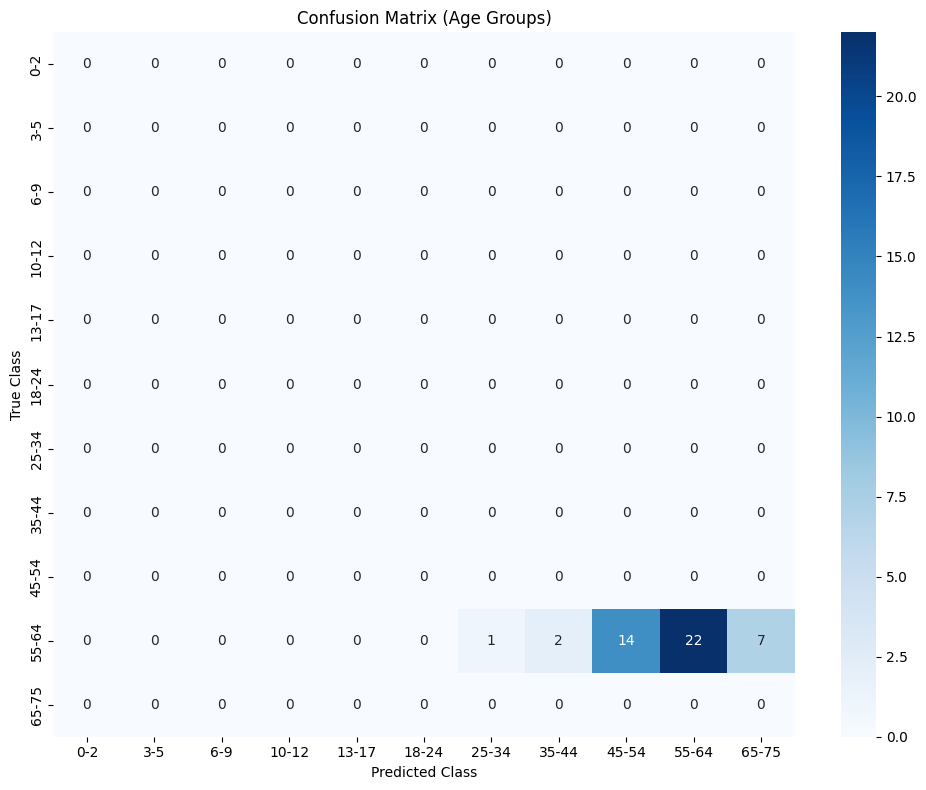

[57] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           7     0.0000    0.0000    0.0000         0
           8     0.0000    0.0000    0.0000         0
           9     1.0000    0.5625    0.7200        16
          10     0.0000    0.0000    0.0000         0

    accuracy                         0.5625        16
   macro avg     0.2500    0.1406    0.1800        16
weighted avg     1.0000    0.5625    0.7200        16


📉 Mean Absolute Error (MAE): 0.5000 (in age group units)


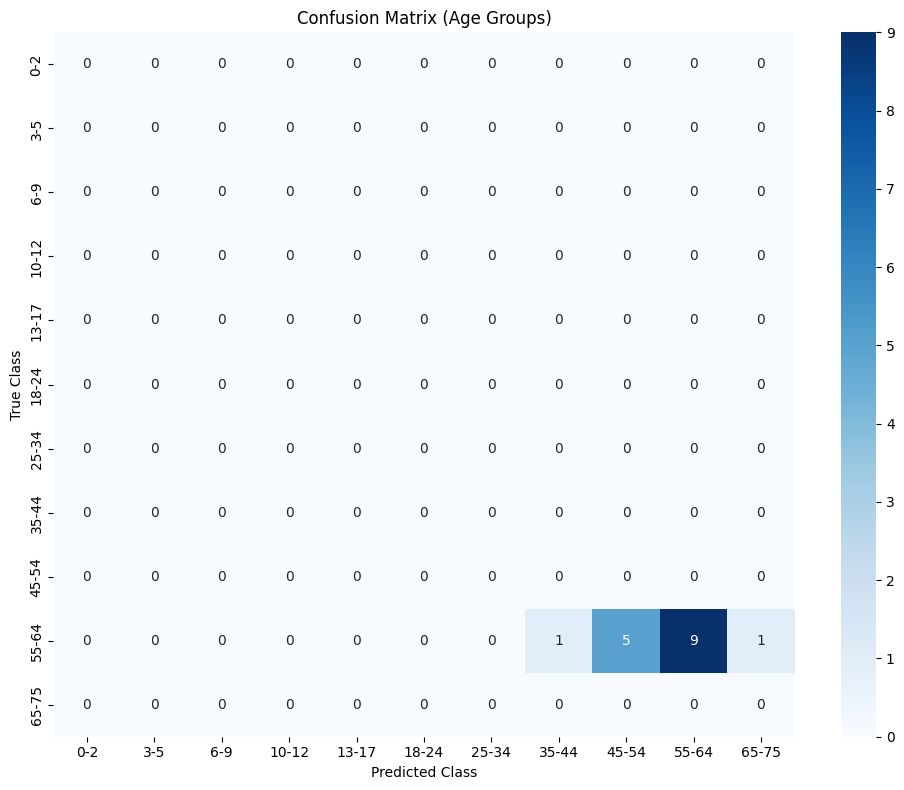

[58] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           7     0.0000    0.0000    0.0000         0
           8     0.0000    0.0000    0.0000         0
           9     1.0000    0.4717    0.6410        53
          10     0.0000    0.0000    0.0000         0

    accuracy                         0.4717        53
   macro avg     0.2500    0.1179    0.1603        53
weighted avg     1.0000    0.4717    0.6410        53


📉 Mean Absolute Error (MAE): 0.5472 (in age group units)


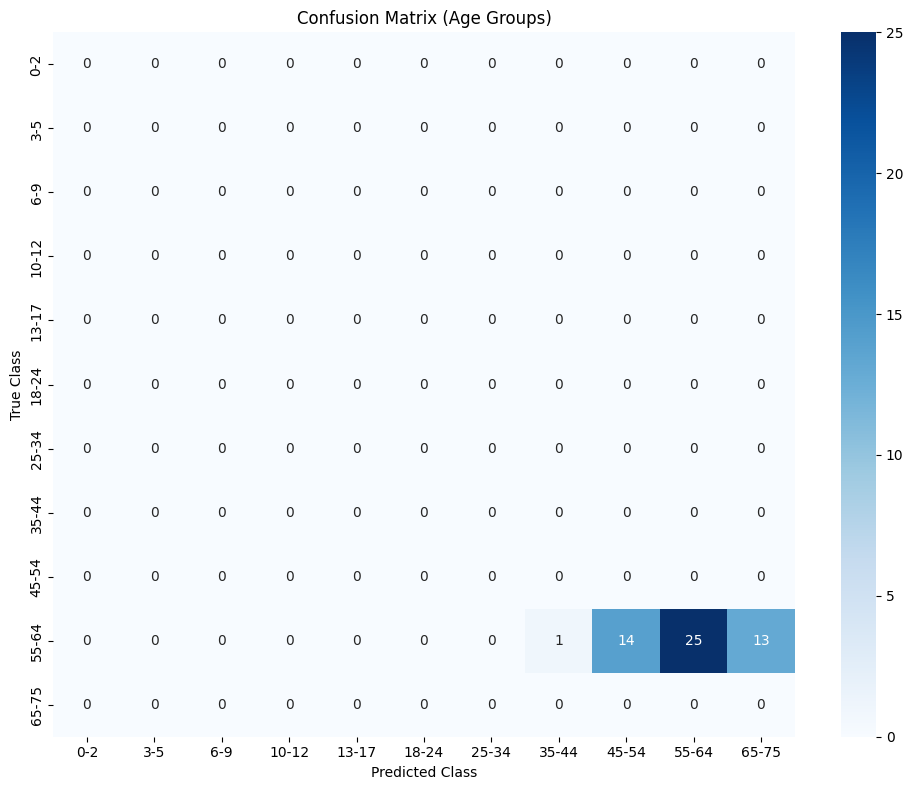

[59] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           7     0.0000    0.0000    0.0000         0
           8     0.0000    0.0000    0.0000         0
           9     1.0000    0.2727    0.4286        11
          10     0.0000    0.0000    0.0000         0

    accuracy                         0.2727        11
   macro avg     0.2500    0.0682    0.1071        11
weighted avg     1.0000    0.2727    0.4286        11


📉 Mean Absolute Error (MAE): 0.9091 (in age group units)


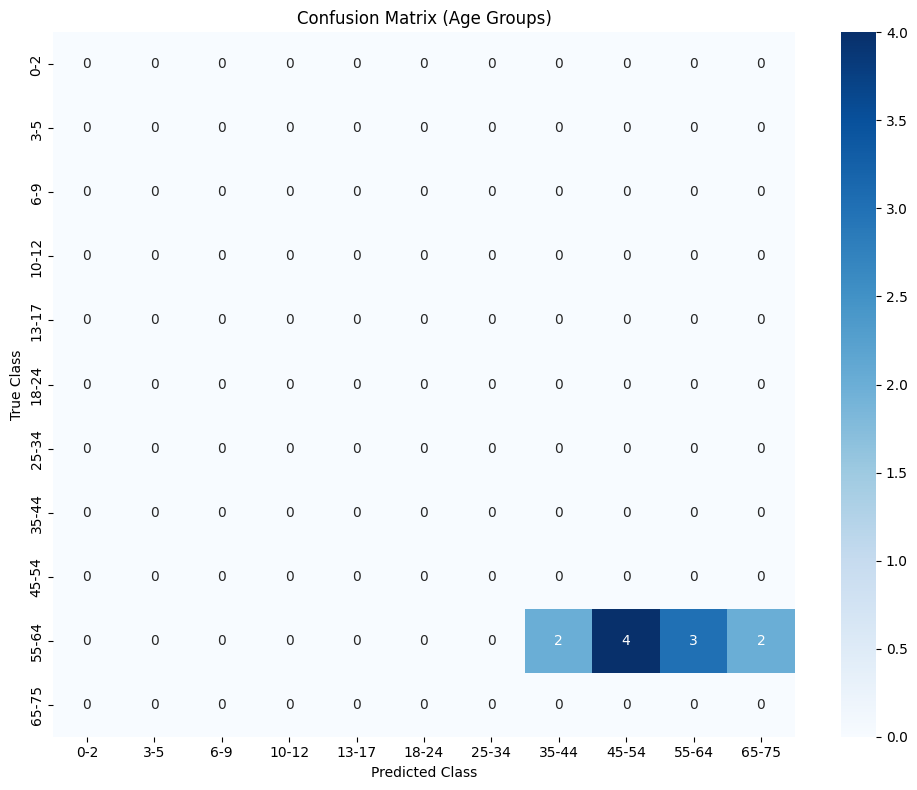

[60] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           7     0.0000    0.0000    0.0000         0
           8     0.0000    0.0000    0.0000         0
           9     1.0000    0.5000    0.6667        46
          10     0.0000    0.0000    0.0000         0

    accuracy                         0.5000        46
   macro avg     0.2500    0.1250    0.1667        46
weighted avg     1.0000    0.5000    0.6667        46


📉 Mean Absolute Error (MAE): 0.5217 (in age group units)


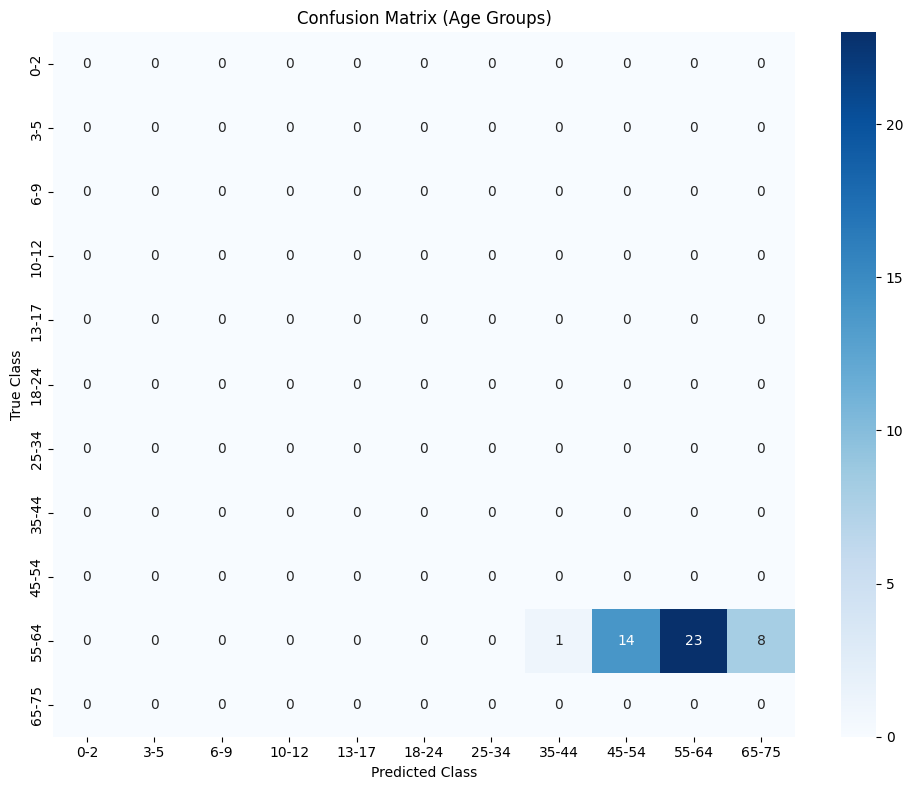

[61] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           6     0.0000    0.0000    0.0000         0
           7     0.0000    0.0000    0.0000         0
           8     0.0000    0.0000    0.0000         0
           9     1.0000    0.4400    0.6111        25
          10     0.0000    0.0000    0.0000         0

    accuracy                         0.4400        25
   macro avg     0.2000    0.0880    0.1222        25
weighted avg     1.0000    0.4400    0.6111        25


📉 Mean Absolute Error (MAE): 0.6800 (in age group units)


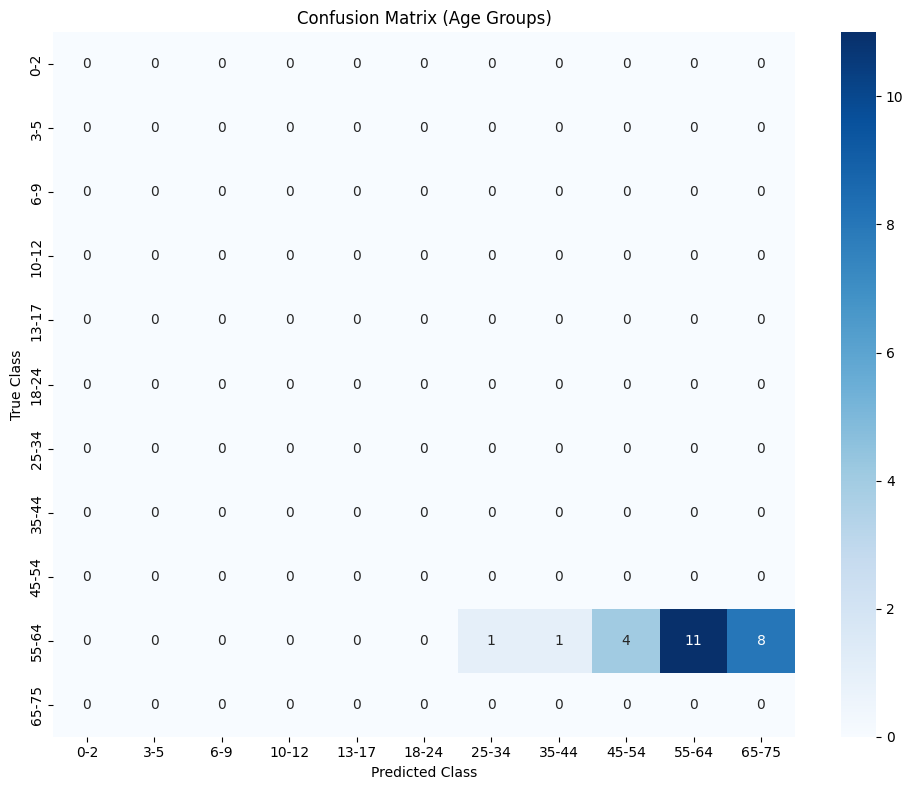

[62] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           7     0.0000    0.0000    0.0000         0
           8     0.0000    0.0000    0.0000         0
           9     1.0000    0.3478    0.5161        23
          10     0.0000    0.0000    0.0000         0

    accuracy                         0.3478        23
   macro avg     0.2500    0.0870    0.1290        23
weighted avg     1.0000    0.3478    0.5161        23


📉 Mean Absolute Error (MAE): 0.7391 (in age group units)


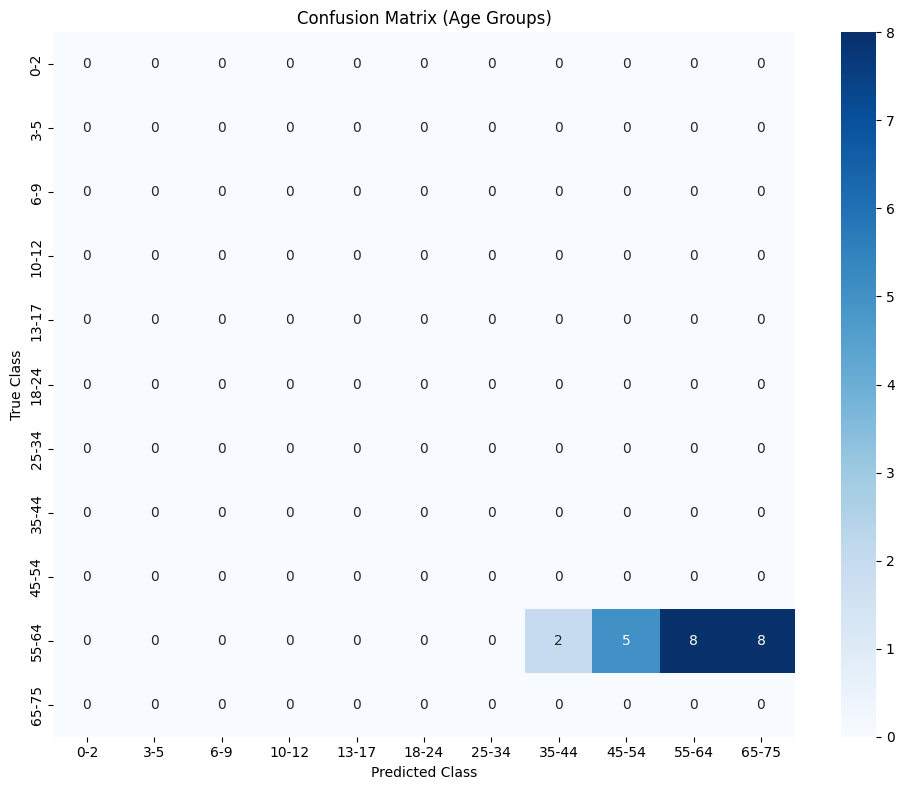

[63] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           6     0.0000    0.0000    0.0000         0
           8     0.0000    0.0000    0.0000         0
           9     1.0000    0.3571    0.5263        14
          10     0.0000    0.0000    0.0000         0

    accuracy                         0.3571        14
   macro avg     0.2500    0.0893    0.1316        14
weighted avg     1.0000    0.3571    0.5263        14


📉 Mean Absolute Error (MAE): 0.7857 (in age group units)


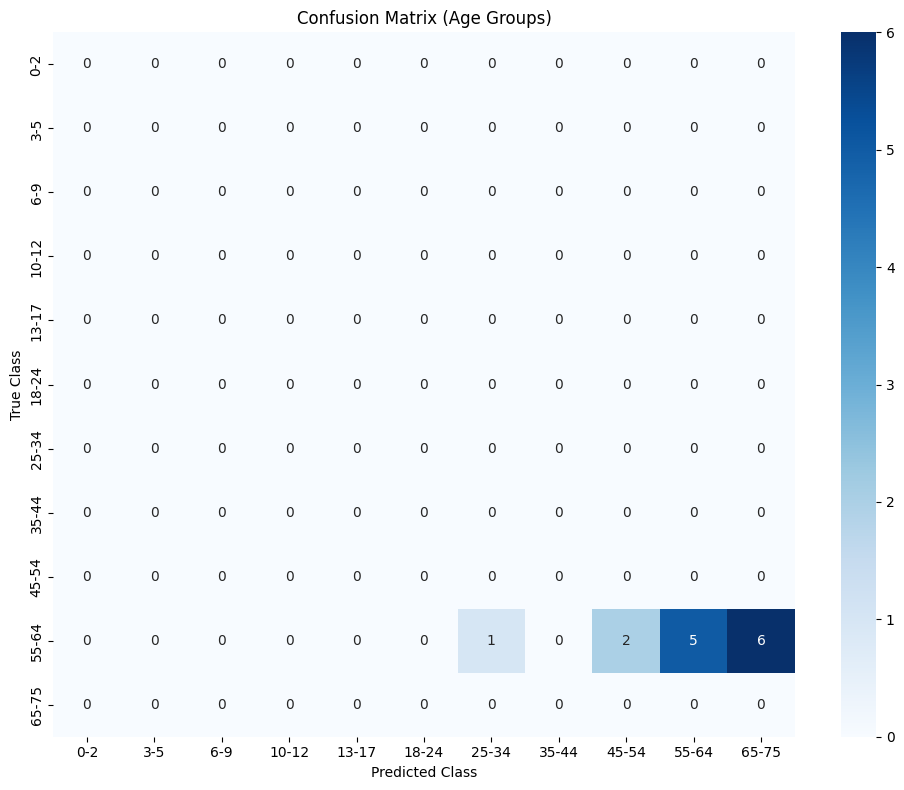

[64] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           8     0.0000    0.0000    0.0000         0
           9     1.0000    0.5455    0.7059        11
          10     0.0000    0.0000    0.0000         0

    accuracy                         0.5455        11
   macro avg     0.3333    0.1818    0.2353        11
weighted avg     1.0000    0.5455    0.7059        11


📉 Mean Absolute Error (MAE): 0.4545 (in age group units)


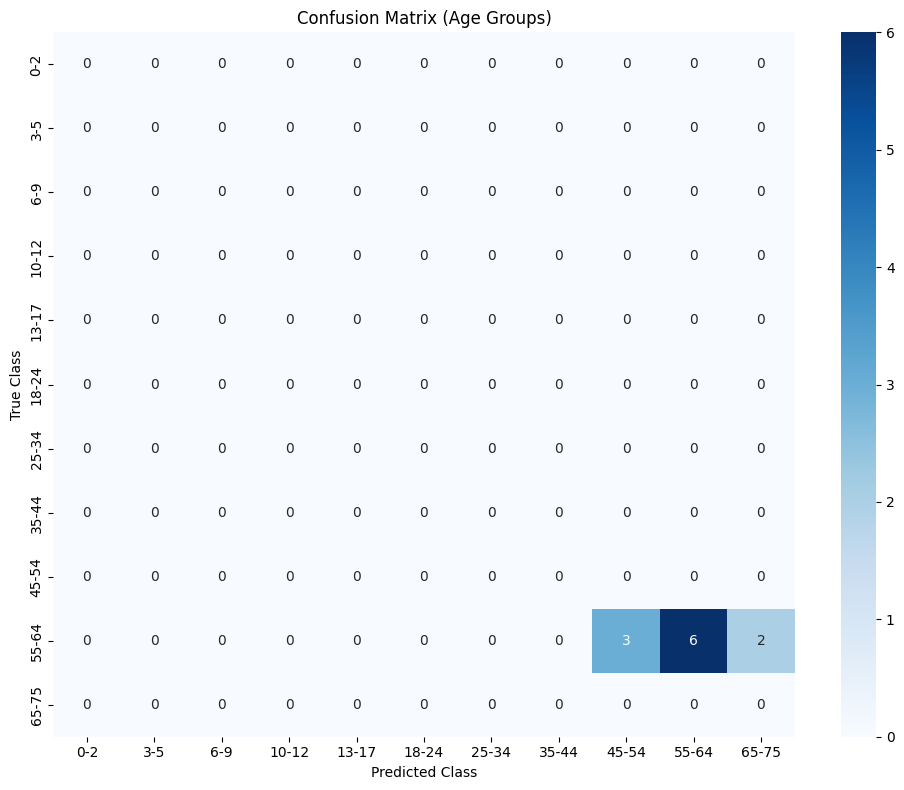

In [ ]:
SELECTED_AGES =[55]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)


SELECTED_AGES =[56]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

SELECTED_AGES =[57]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)


SELECTED_AGES =[58]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

SELECTED_AGES =[59]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

SELECTED_AGES =[60]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)


SELECTED_AGES =[61]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

SELECTED_AGES =[62]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)


SELECTED_AGES =[63]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

SELECTED_AGES =[64]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

### (65-75)

[65] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           7     0.0000    0.0000    0.0000         0
           8     0.0000    0.0000    0.0000         0
           9     0.0000    0.0000    0.0000         0
          10     1.0000    0.3030    0.4651        33

    accuracy                         0.3030        33
   macro avg     0.2500    0.0758    0.1163        33
weighted avg     1.0000    0.3030    0.4651        33


📉 Mean Absolute Error (MAE): 1.1515 (in age group units)


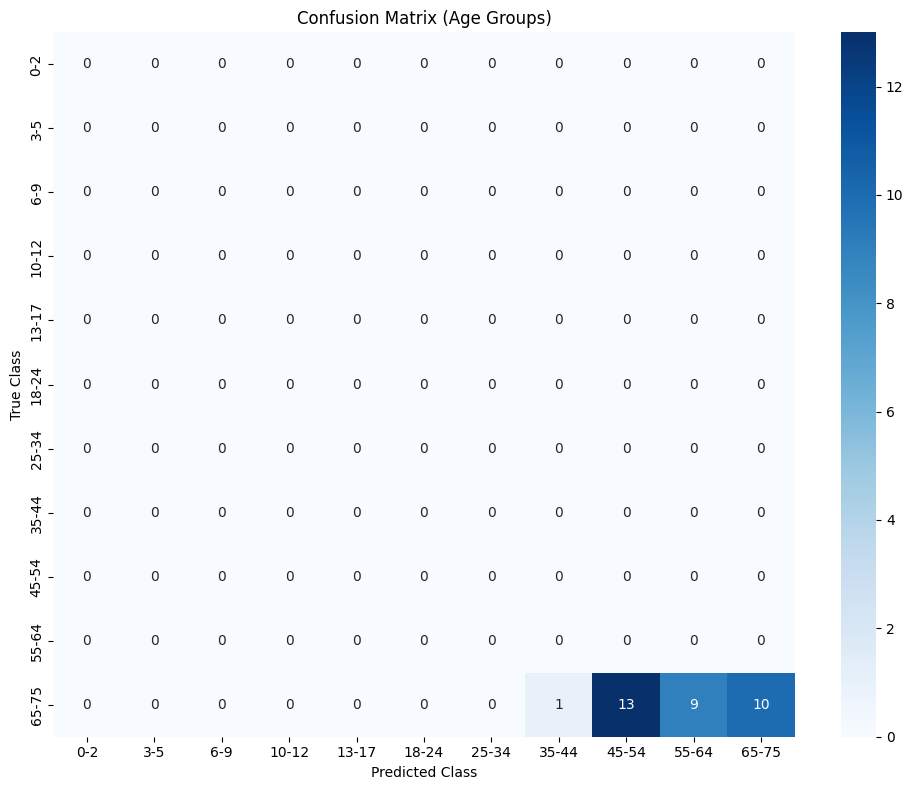

[66] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           6     0.0000    0.0000    0.0000         0
           9     0.0000    0.0000    0.0000         0
          10     1.0000    0.7273    0.8421        11

    accuracy                         0.7273        11
   macro avg     0.3333    0.2424    0.2807        11
weighted avg     1.0000    0.7273    0.8421        11


📉 Mean Absolute Error (MAE): 0.5455 (in age group units)


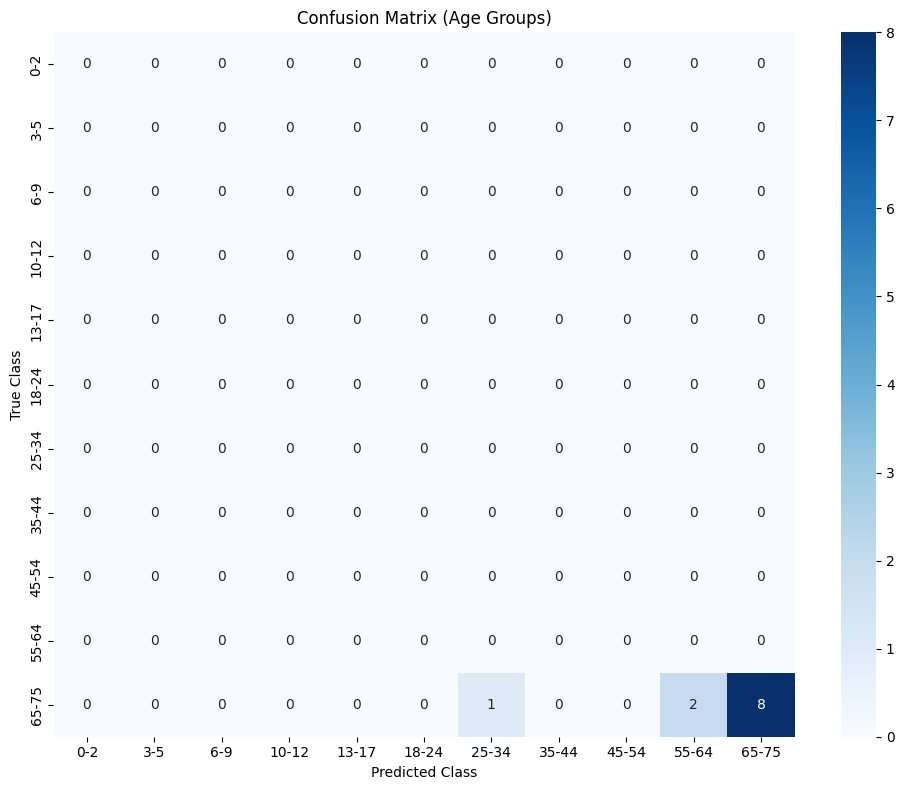

[67] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           8     0.0000    0.0000    0.0000         0
           9     0.0000    0.0000    0.0000         0
          10     1.0000    0.7500    0.8571        12

    accuracy                         0.7500        12
   macro avg     0.3333    0.2500    0.2857        12
weighted avg     1.0000    0.7500    0.8571        12


📉 Mean Absolute Error (MAE): 0.3333 (in age group units)


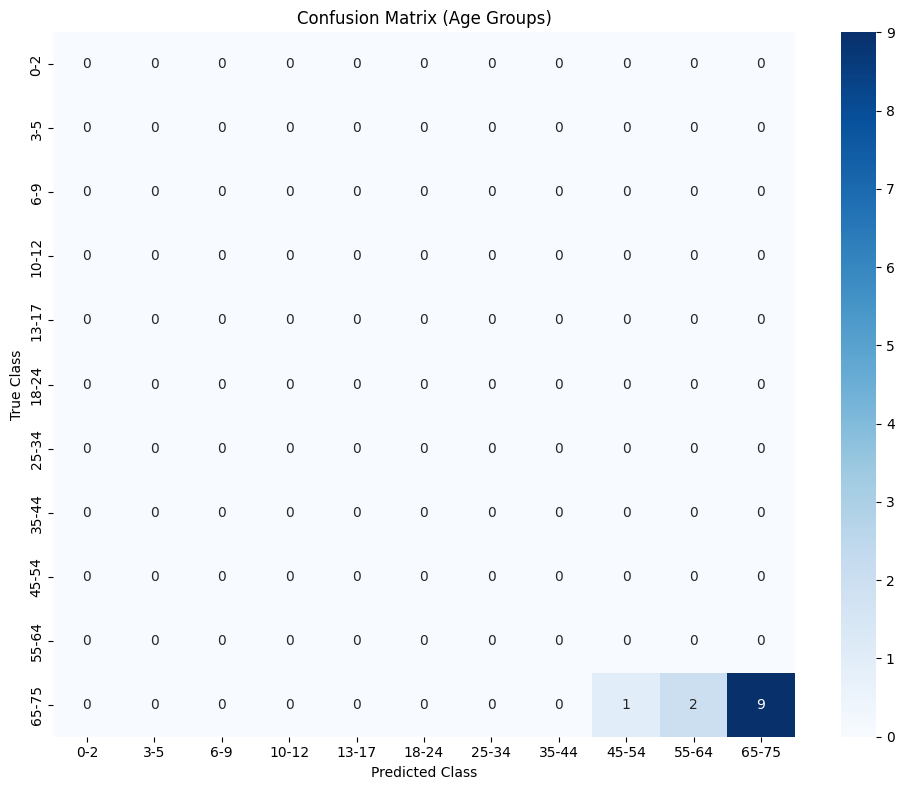

[68] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           8     0.0000    0.0000    0.0000         0
           9     0.0000    0.0000    0.0000         0
          10     1.0000    0.5263    0.6897        19

    accuracy                         0.5263        19
   macro avg     0.3333    0.1754    0.2299        19
weighted avg     1.0000    0.5263    0.6897        19


📉 Mean Absolute Error (MAE): 0.5789 (in age group units)


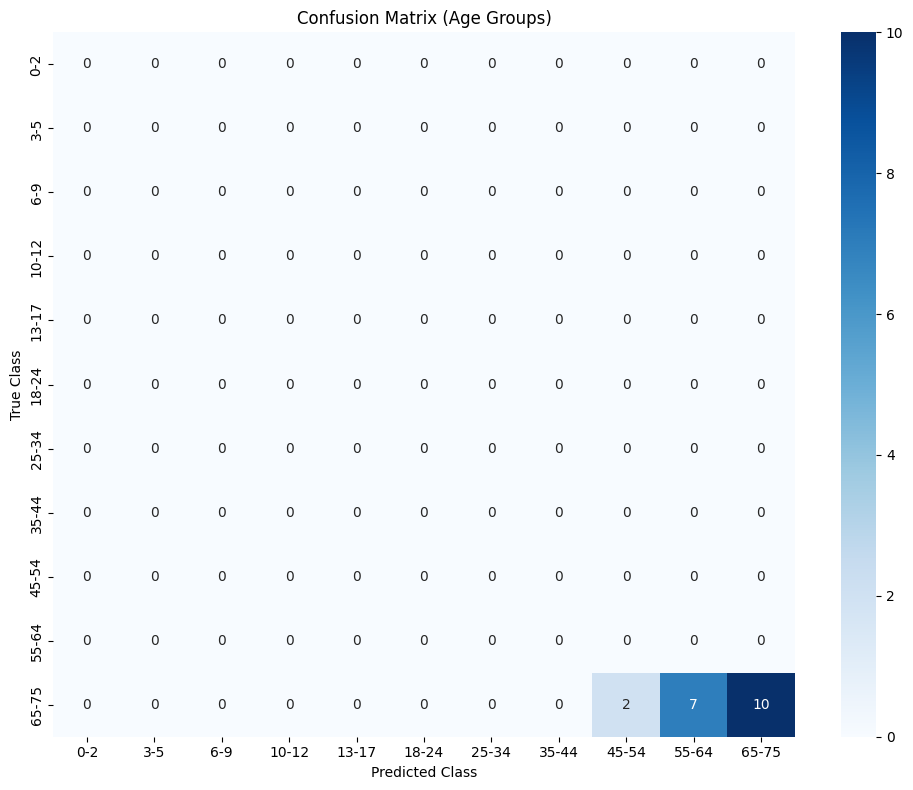

[69] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           7     0.0000    0.0000    0.0000         0
          10     1.0000    0.7500    0.8571         4

    accuracy                         0.7500         4
   macro avg     0.5000    0.3750    0.4286         4
weighted avg     1.0000    0.7500    0.8571         4


📉 Mean Absolute Error (MAE): 0.7500 (in age group units)


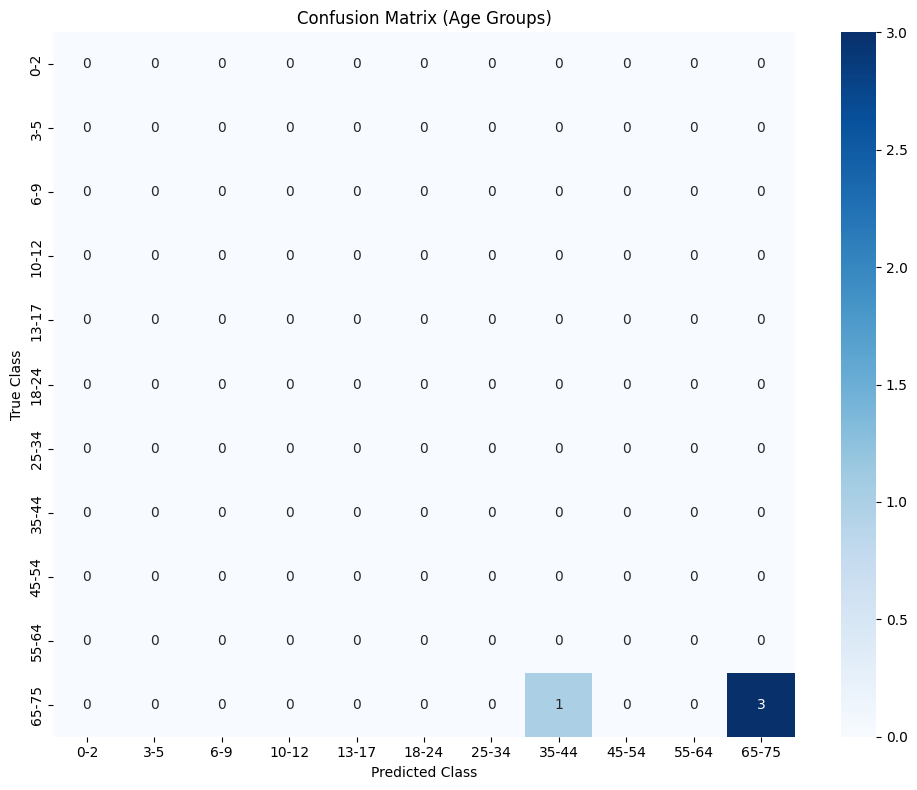

[70] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           9     0.0000    0.0000    0.0000         0
          10     1.0000    0.8000    0.8889        15

    accuracy                         0.8000        15
   macro avg     0.5000    0.4000    0.4444        15
weighted avg     1.0000    0.8000    0.8889        15


📉 Mean Absolute Error (MAE): 0.2000 (in age group units)


[71] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           9     0.0000    0.0000    0.0000         0
          10     1.0000    0.8571    0.9231         7

    accuracy                         0.8571         7
   macro avg     0.5000    0.4286    0.4615         7
weighted avg     1.0000    0.8571    0.9231         7


📉 Mean Absolute Error (MAE): 0.1429 (in age group units)


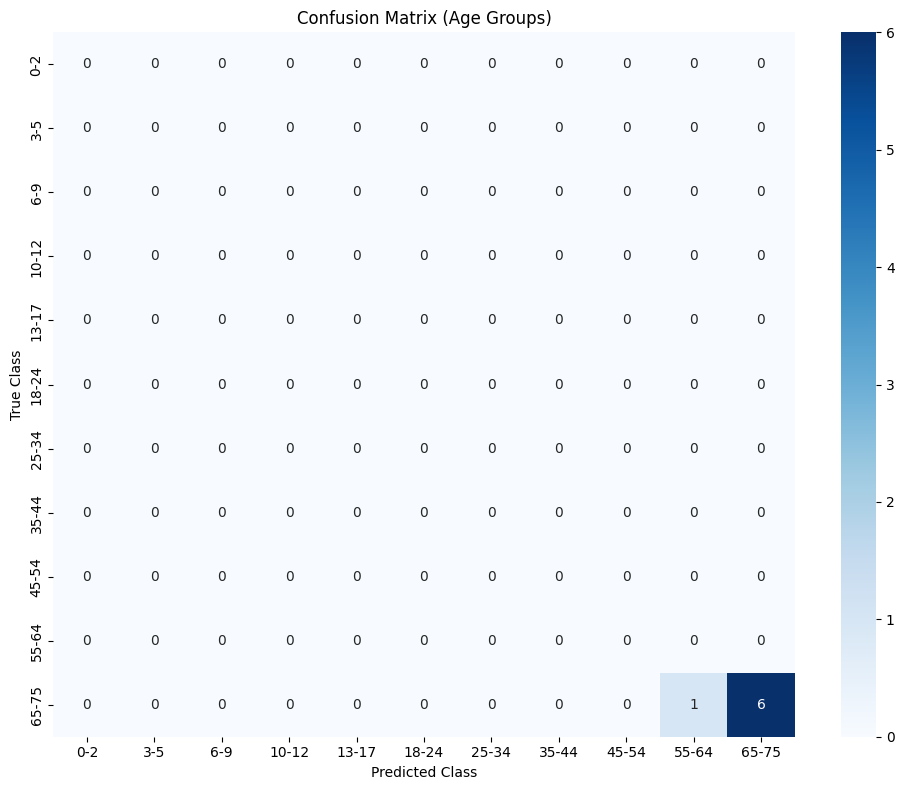

[72] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           9     0.0000    0.0000    0.0000         0
          10     1.0000    0.7143    0.8333        14

    accuracy                         0.7143        14
   macro avg     0.5000    0.3571    0.4167        14
weighted avg     1.0000    0.7143    0.8333        14


📉 Mean Absolute Error (MAE): 0.2857 (in age group units)


[73] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

          10     1.0000    1.0000    1.0000         6

    accuracy                         1.0000         6
   macro avg     1.0000    1.0000    1.0000         6
weighted avg     1.0000    1.0000    1.0000         6


📉 Mean Absolute Error (MAE): 0.0000 (in age group units)


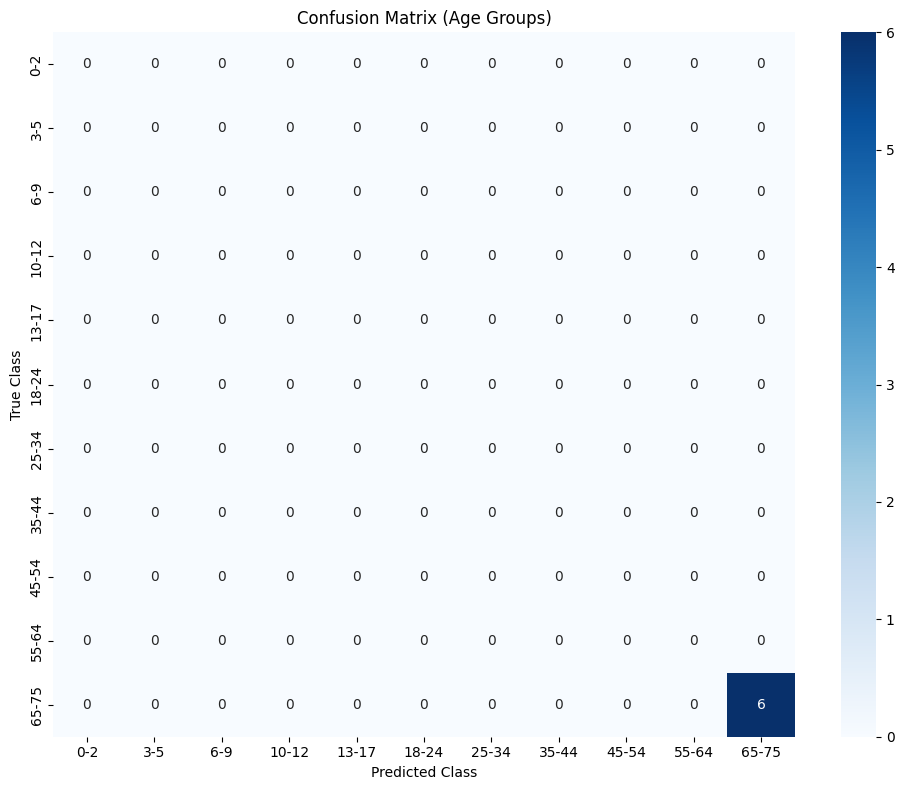

[74] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           8     0.0000    0.0000    0.0000         0
          10     1.0000    0.8333    0.9091         6

    accuracy                         0.8333         6
   macro avg     0.5000    0.4167    0.4545         6
weighted avg     1.0000    0.8333    0.9091         6


📉 Mean Absolute Error (MAE): 0.3333 (in age group units)


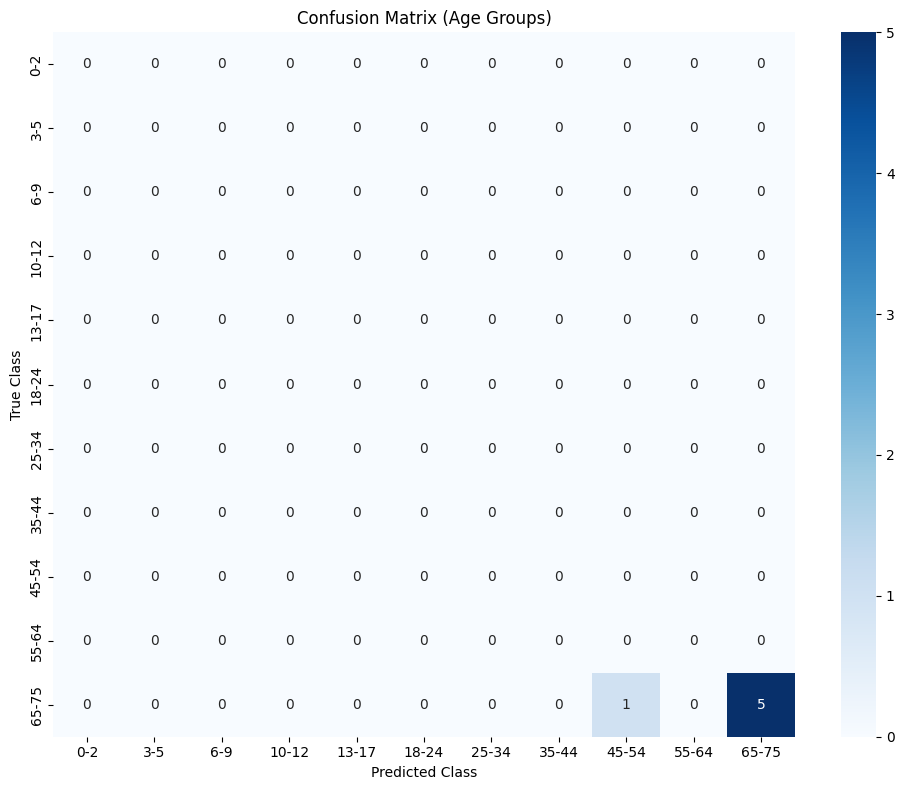

[75] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           9     0.0000    0.0000    0.0000         0
          10     1.0000    0.8333    0.9091        24

    accuracy                         0.8333        24
   macro avg     0.5000    0.4167    0.4545        24
weighted avg     1.0000    0.8333    0.9091        24


📉 Mean Absolute Error (MAE): 0.1667 (in age group units)


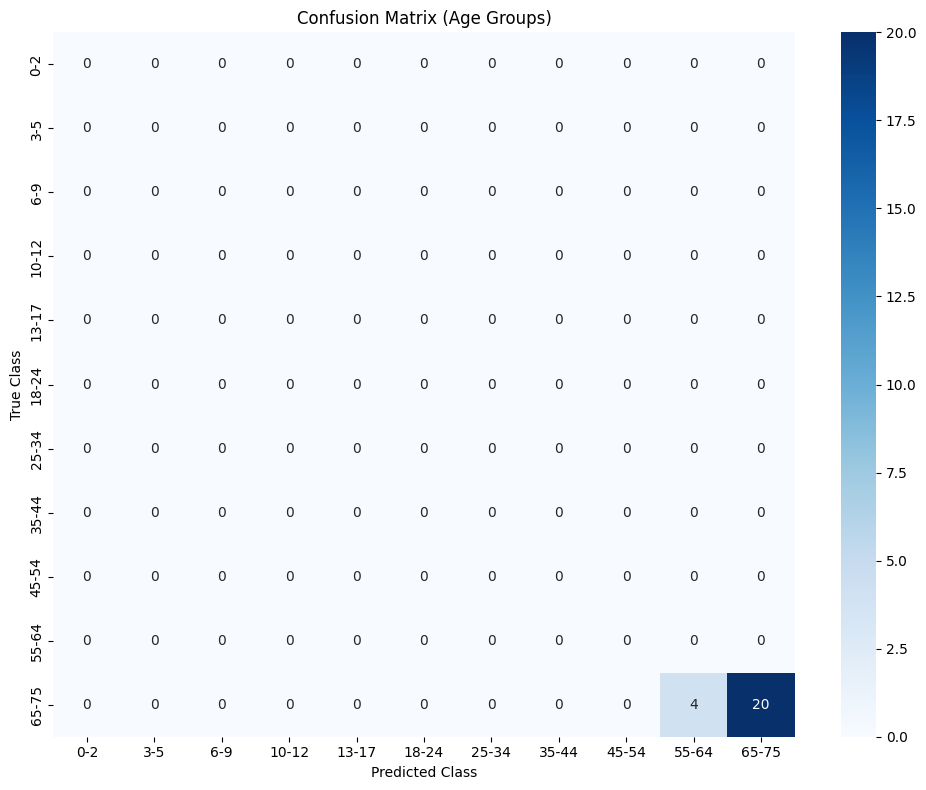

In [ ]:
SELECTED_AGES =[65]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)


SELECTED_AGES =[66]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

SELECTED_AGES =[67]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)


SELECTED_AGES =[68]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

SELECTED_AGES =[69]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

SELECTED_AGES =[70]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)


SELECTED_AGES =[71]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

SELECTED_AGES =[72]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)


SELECTED_AGES =[73]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

SELECTED_AGES =[74]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

SELECTED_AGES =[75]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

[65] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           7     0.0000    0.0000    0.0000         0
           8     0.0000    0.0000    0.0000         0
           9     0.0000    0.0000    0.0000         0
          10     1.0000    0.3030    0.4651        33

    accuracy                         0.3030        33
   macro avg     0.2500    0.0758    0.1163        33
weighted avg     1.0000    0.3030    0.4651        33


📉 Mean Absolute Error (MAE): 1.1515 (in age group units)


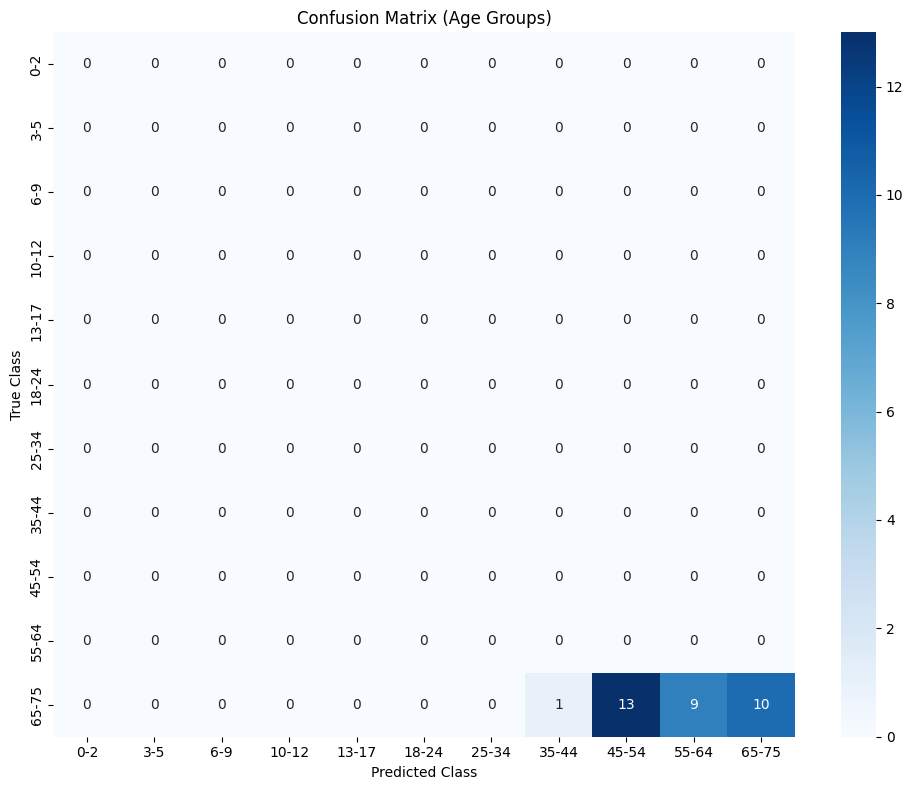

[66, 67, 68, 69, 70, 71, 72, 73, 74, 75] years old evaluation

📊 Classification Report:
              precision    recall  f1-score   support

           6     0.0000    0.0000    0.0000         0
           7     0.0000    0.0000    0.0000         0
           8     0.0000    0.0000    0.0000         0
           9     0.0000    0.0000    0.0000         0
          10     1.0000    0.7542    0.8599       118

    accuracy                         0.7542       118
   macro avg     0.2000    0.1508    0.1720       118
weighted avg     1.0000    0.7542    0.8599       118


📉 Mean Absolute Error (MAE): 0.3220 (in age group units)


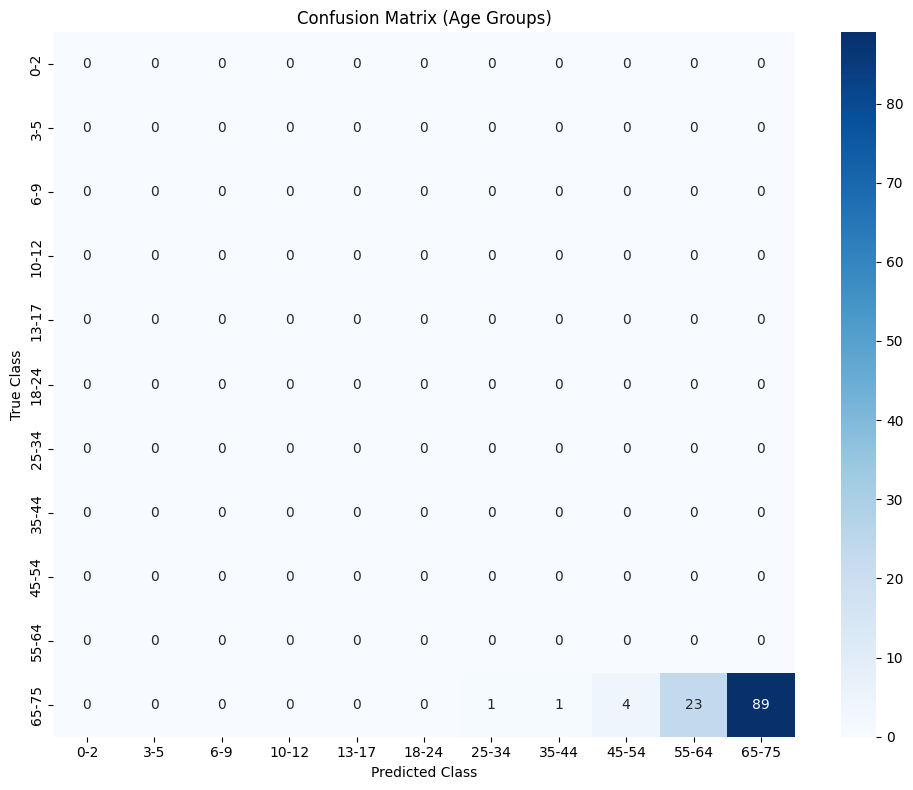

In [ ]:
SELECTED_AGES =[65]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

SELECTED_AGES =[66,67,68,69,70,71,72,73,74,75]  # ← Modify as needed
print(SELECTED_AGES,"years old evaluation")
subset= get_selected_subset_by_age(test_dataset, SELECTED_AGES)
evaluate_detailed_metrics(model, subset)

## With best weights (Data augmentation)



📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9129    0.8907    0.9016       247
           1     0.6571    0.5897    0.6216       117
           2     0.5824    0.4862    0.5300       109
           3     0.3273    0.8182    0.4675        44
           4     0.2937    0.6695    0.4083       118
           5     0.3677    0.6066    0.4579       394
           6     0.6674    0.2607    0.3749      1124
           7     0.3478    0.4214    0.3810       515
           8     0.3652    0.4636    0.4085       330
           9     0.3632    0.2840    0.3188       257
          10     0.4484    0.7200    0.5526       175

    accuracy                         0.4542      3430
   macro avg     0.4848    0.5646    0.4930      3430
weighted avg     0.5193    0.4542    0.4471      3430


📉 Mean Absolute Error (MAE): 0.6948 (in age group units)


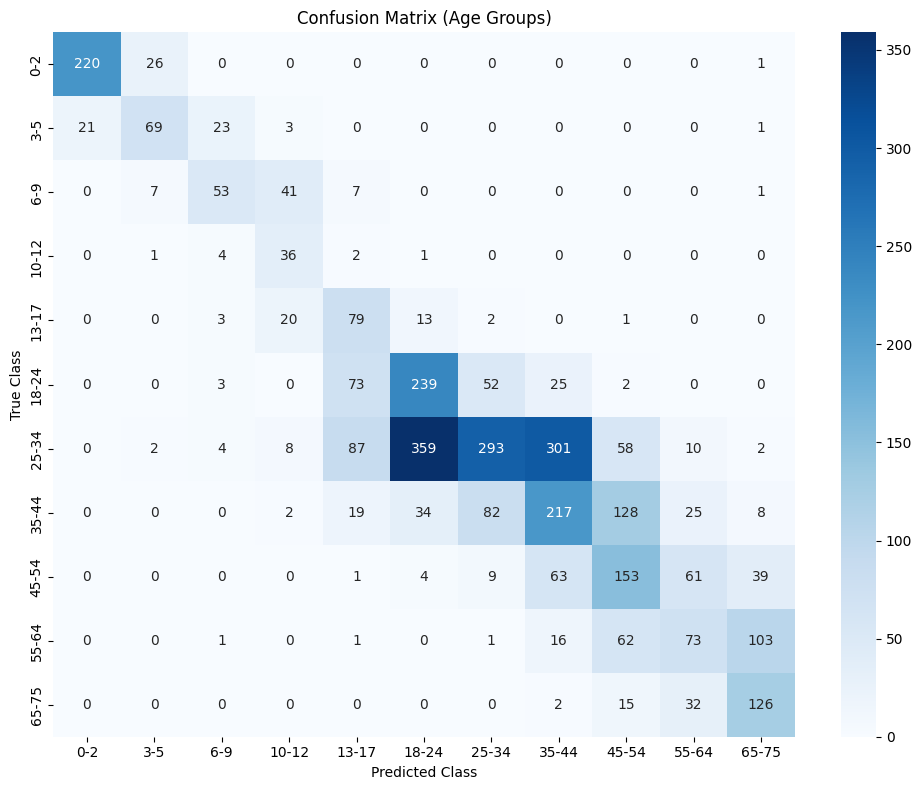

In [16]:
evaluate_detailed_metrics(model, test_dataset)